# Global Explainer - Mutagenicity
PGExplainer pretrained TF version

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from local_explanations import *
import utils
import models

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os
import numpy as np
import wandb
import networkx as nx
from networkx.algorithms import isomorphism
from networkx.generators import classic

import torch
from torch_geometric.nn import GAE, VGAE, GCNConv
import torch_geometric.transforms as T
from torch_geometric.data import InMemoryDataset, download_url, Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.loader import DataLoader
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score

import copy
import random
from scipy.stats import hmean

from collections import defaultdict
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool, global_max_pool, GATConv, GINConv
from torch_scatter import scatter
import torch_explain as te
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity, test_explanations
from torch_geometric.datasets import MNISTSuperpixels


%load_ext autoreload
%autoreload 2

In [3]:
def plot_mol(data, adj=None, node_features=None):
    if adj is None and node_features is None:
        G = to_networkx(data)
    else:
        G = nx.from_numpy_matrix(adj)
    node_label = data.x.argmax(-1) if node_features is None else node_features.argmax(-1)
    max_label = node_label.max() + 1
    nmb_nodes = len(node_label)
    
    colors = ['orange','red','lime','green','blue','orchid','darksalmon','darkslategray','gold','bisque','tan','lightseagreen','indigo','navy']
    label2nodes = []
    for i in range(max_label):
        label2nodes.append([])
    for i in range(nmb_nodes):
        if i in G.nodes():
            label2nodes[node_label[i]].append(i)
            
    if adj is not None and node_features is not None:
        G.remove_edges_from(nx.selfloop_edges(G))
        G.remove_nodes_from(list(nx.isolates(G)))
            
    pos = nx.kamada_kawai_layout(G)
    for i in range(max_label):
        node_filter = []
        for j in range(len(label2nodes[i])):
            node_filter.append(label2nodes[i][j])
        nx.draw_networkx_nodes(G, pos,
                               nodelist=node_filter,
                               node_color=colors[i],
                               node_size=300)
        nx.draw_networkx_labels(G, pos, {k:k for k in node_filter})

    nx.draw_networkx_edges(G, pos, width=2,  edge_color='grey')
    plt.axis('off')
    plt.show()

In [54]:
adjs_train , \
edge_weights_train , \
ori_adjs_train , \
ori_classes_train , \
belonging_train , \
summary_predictions_train , \
le_classes_train ,\
embeddings_train = read_mutagenicity(evaluate_method=False, 
                                     manual_cut=0.42392886, #0.42392886
                                     split="TRAIN")

print(np.unique(le_classes_train, return_counts=True))

belonging_train2 = np.array(belonging_train)
le_classes_train = np.array(le_classes_train)
c = 0
for b in np.unique(belonging_train):
    if ori_classes_train[b] == 1 and 0 in le_classes_train[belonging_train2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_train))
c = 0
for b in np.unique(belonging_train):
    if ori_classes_train[b] == 0 and 0 not in le_classes_train[belonging_train2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_train))

print(len(adjs_train) , len(edge_weights_train), len(ori_adjs_train) , len(ori_classes_train) , len(belonging_train))
np.unique(summary_predictions_train["wrong"], return_counts=True) , np.unique(summary_predictions_train["correct"], return_counts=True)

(array([0, 1]), array([593, 162], dtype=int64))
Samples of class 1 containing NO2:  0.05415162454873646
Samples of class 0 not containing NO2:  0.09205776173285199
755 755 554 554 755


((array([], dtype=float64), array([], dtype=int64)),
 (array([0, 1]), array([1921, 1548], dtype=int64)))

In [55]:
adjs_val , \
edge_weights_val , \
ori_adjs_val , \
ori_classes_val , \
belonging_val , \
summary_predictions_val , \
le_classes_val ,\
embeddings_val = read_mutagenicity(evaluate_method=False, 
                                   manual_cut=0.42392886,
                                   split="VAL")

print(np.unique(le_classes_val, return_counts=True))

belonging_val2 = np.array(belonging_val)
le_classes_val = np.array(le_classes_val)
c = 0
for b in np.unique(belonging_val):
    if ori_classes_val[b] == 1 and 0 in le_classes_val[belonging_val2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_val))
c = 0
for b in np.unique(belonging_val):
    if ori_classes_val[b] == 0 and 0 not in le_classes_val[belonging_val2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_val))

print(len(adjs_val) , len(edge_weights_val), len(ori_adjs_val) , len(ori_classes_val) , len(belonging_val))
np.unique(summary_predictions_val["wrong"], return_counts=True) , np.unique(summary_predictions_val["correct"], return_counts=True)

(array([0, 1]), array([80, 21], dtype=int64))
Samples of class 1 containing NO2:  0.029411764705882353
Samples of class 0 not containing NO2:  0.08823529411764706
101 101 68 68 101


((array([], dtype=float64), array([], dtype=int64)),
 (array([0, 1]), array([245, 189], dtype=int64)))

In [56]:
adjs_test , \
edge_weights_test , \
ori_adjs_test , \
ori_classes_test , \
belonging_test , \
summary_predictions_test , \
le_classes_test ,\
embeddings_test = read_mutagenicity(evaluate_method=False, 
                                   manual_cut=0.42392886,
                                   split="TEST")

print(np.unique(le_classes_test, return_counts=True))

belonging_test2 = np.array(belonging_test)
le_classes_test = np.array(le_classes_test)
c = 0
for b in np.unique(belonging_test):
    if ori_classes_test[b] == 1 and 0 in le_classes_test[belonging_test2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_test))
c = 0
for b in np.unique(belonging_test):
    if ori_classes_test[b] == 0 and 0 not in le_classes_test[belonging_test2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_test))

print(len(adjs_test) , len(edge_weights_test), len(ori_adjs_test) , len(ori_classes_test) , len(belonging_test))
np.unique(summary_predictions_test["wrong"], return_counts=True) , np.unique(summary_predictions_test["correct"], return_counts=True)

(array([0, 1]), array([68, 23], dtype=int64))
Samples of class 1 containing NO2:  0.014285714285714285
Samples of class 0 not containing NO2:  0.1
91 91 70 70 91


((array([], dtype=float64), array([], dtype=int64)),
 (array([0, 1]), array([235, 199], dtype=int64)))

In [ ]:
belonging_train = np.array(belonging_train)
idxs = np.nonzero(belonging_train == 26)[0]
for idx in idxs:
    print(ori_idxs_train[idx])
    plot_mol(train_dataset[idx])

### Dataset

C:\Users\Steve\Desktop\GNN\gnn_logic_global_expl\code\utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr=torch.tensor(t.weight).reshape(-1, 1),


(array([0, 1]), array([593, 162], dtype=int64))
(tensor([0, 1]), tensor([650, 105]))


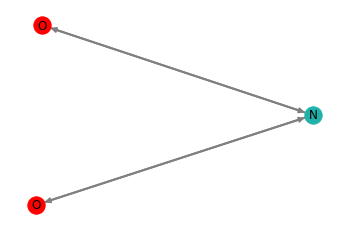

(14, tensor([14]), tensor([0]))

In [57]:
device = "cpu" #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = None  

dataset_train = utils.LocalExplanationsDataset("", adjs_train, edge_weights_test, "embeddings", transform=transform, y=le_classes_train, belonging=belonging_train, task_y=ori_classes_train, precomputed_embeddings=embeddings_train)
dataset_val = utils.LocalExplanationsDataset("", adjs_val, edge_weights_val, "embeddings", transform=transform, y=le_classes_val, belonging=belonging_val, task_y=ori_classes_val, precomputed_embeddings=embeddings_val)
dataset_test = utils.LocalExplanationsDataset("", adjs_test, edge_weights_test, "embeddings", transform=transform, y=le_classes_test, belonging=belonging_test, task_y=ori_classes_test, precomputed_embeddings=embeddings_test)


##
# debug Dataset
##
print(np.unique(le_classes_train, return_counts=True))
print(torch.unique(dataset_train.data.task_y, return_counts=True))
idx = 18
utils.plot_molecule(dataset_train[idx])
belonging_train[idx] , dataset_train[idx].graph_id,dataset_train[idx].y

In [ ]:
for i in range(10):
    #if dataset[i].y != 0:
    #    continue
    print(train_dataset[i].y)
    plot_mol(train_dataset[i])

(array([0., 1.], dtype=float32), array([593, 162], dtype=int64))


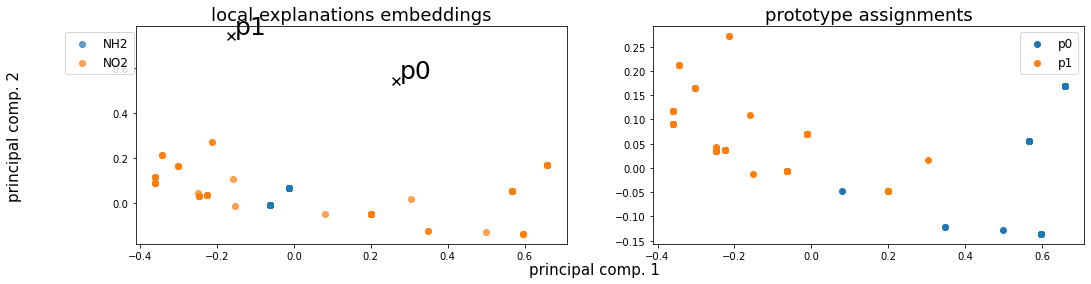

Alpha norms:
tensor([[1.0000, 0.6722],
        [0.7495, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.923571 +- 0.076429
Concept distribution:  (array([0, 1], dtype=int64), array([ 55, 700], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.15627, LEN: 0.036341, AccxC: 0.14, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.17191, V. LEN 0.04
  2: Loss: 0.12450, LEN: 0.036126, AccxC: 0.68, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.14204, V. LEN 0.04
  3: Loss: 0.10075, LEN: 0.035961, AccxC: 0.86, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.12129, V. LEN 0.04
  4: Loss: 0.08270, LEN: 0.035803, AccxC: 0.86, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.09757, V. LEN 0.04
  5: Loss: 0.06345, LEN: 0.035655, AccxC: 0.86, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.07587, V. LEN 0.04
  6: Loss: 0.05010, LEN: 0.035449, AccxC: 0.86, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.06153, V. LEN 0.04
  7: Loss: 0.04329, LEN: 0.035332, AccxC: 0.86, AccO:

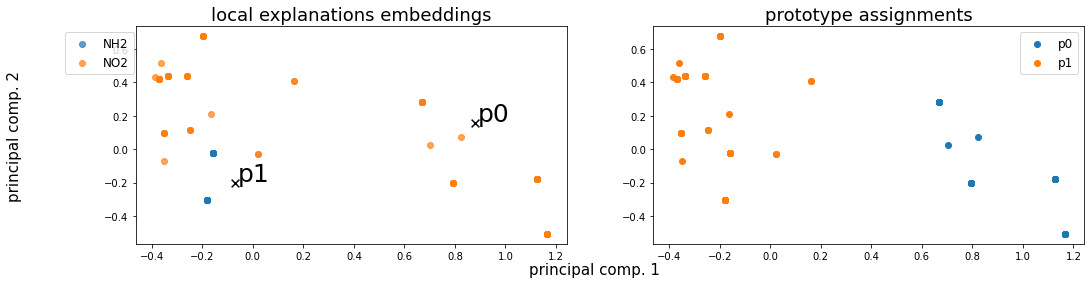

Alpha norms:
tensor([[1.0000, 0.8146],
        [0.7397, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.969889 +- 0.030111
Concept distribution:  (array([0, 1], dtype=int64), array([124, 631], dtype=int64))
Logic formulas:
For class 0:
0.8592057761732852 ((feature001) | ((feature001 & feature000)
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.7906)


 20: Loss: 0.03411, LEN: 0.032958, AccxC: 0.86, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.04440, V. LEN 0.04
 21: Loss: 0.03367, LEN: 0.032644, AccxC: 0.86, AccO: 0.80, V. Acc: 0.84, V. Loss: 0.04296, V. LEN 0.04
 22: Loss: 0.03320, LEN: 0.032392, AccxC: 0.86, AccO: 0.80, V. Acc: 0.84, V. Loss: 0.04285, V. LEN 0.04
 23: Loss: 0.03283, LEN: 0.032206, AccxC: 0.86, AccO: 0.80, V. Acc: 0.84, V. Loss: 0.04287, V. LEN 0.04
 24: Loss: 0.03307, LEN: 0.032135, AccxC: 0.86, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.04250, V. LEN 0.04
 25: Loss: 0.03223, LEN: 0.031661, AccxC: 0.86, AccO: 0.80, V. Acc: 0.84, V. Loss: 0.04242, V. LE

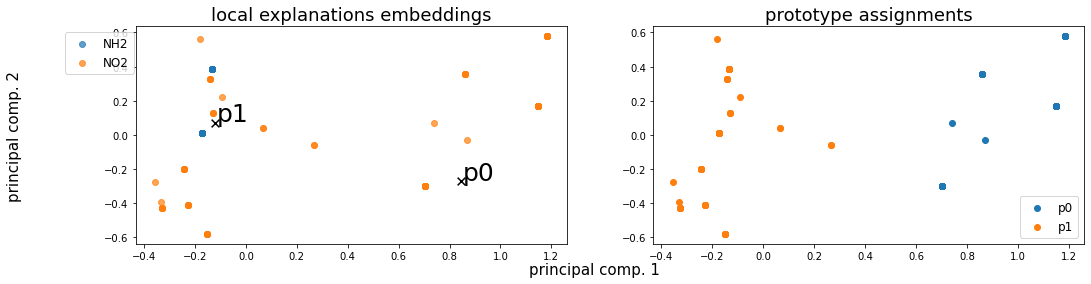

Alpha norms:
tensor([[0.9326, 1.0000],
        [0.6977, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.969889 +- 0.030111
Concept distribution:  (array([0, 1], dtype=int64), array([124, 631], dtype=int64))
Logic formulas:
For class 0:
0.8592057761732852 (feature001) | ((feature000 & feature001)
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.7906)


 40: Loss: 0.02843, LEN: 0.027523, AccxC: 0.86, AccO: 0.80, V. Acc: 0.84, V. Loss: 0.03420, V. LEN 0.03
 41: Loss: 0.02795, LEN: 0.027374, AccxC: 0.86, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.03468, V. LEN 0.03
 42: Loss: 0.02819, LEN: 0.027387, AccxC: 0.86, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.03477, V. LEN 0.03
 43: Loss: 0.02799, LEN: 0.027358, AccxC: 0.86, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.03450, V. LEN 0.03
 44: Loss: 0.02728, LEN: 0.026583, AccxC: 0.86, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.03446, V. LEN 0.03
 45: Loss: 0.02715, LEN: 0.026389, AccxC: 0.86, AccO: 0.80, V. Acc: 0.84, V. Loss: 0.03444, V. LEN

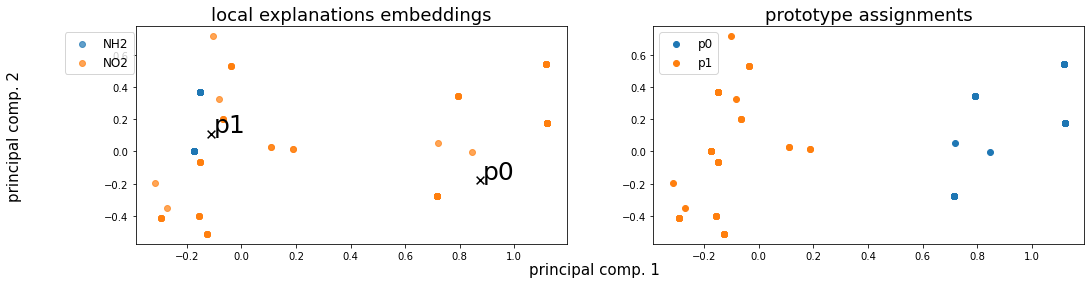

Alpha norms:
tensor([[0.8355, 1.0000],
        [0.7200, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.969889 +- 0.030111
Concept distribution:  (array([0, 1], dtype=int64), array([124, 631], dtype=int64))
Logic formulas:
For class 0:
0.8592057761732852 (feature001) | ((feature000 & feature001)
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.7906)


 60: Loss: 0.02455, LEN: 0.023618, AccxC: 0.86, AccO: 0.80, V. Acc: 0.84, V. Loss: 0.02945, V. LEN 0.03
 61: Loss: 0.02357, LEN: 0.023069, AccxC: 0.86, AccO: 0.80, V. Acc: 0.84, V. Loss: 0.02977, V. LEN 0.03
 62: Loss: 0.02331, LEN: 0.022684, AccxC: 0.86, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.03038, V. LEN 0.03
 63: Loss: 0.02291, LEN: 0.022301, AccxC: 0.86, AccO: 0.80, V. Acc: 0.84, V. Loss: 0.03042, V. LEN 0.03
 64: Loss: 0.02290, LEN: 0.022536, AccxC: 0.86, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.03044, V. LEN 0.03
 65: Loss: 0.02329, LEN: 0.022903, AccxC: 0.86, AccO: 0.80, V. Acc: 0.84, V. Loss: 0.03031, V. LEN

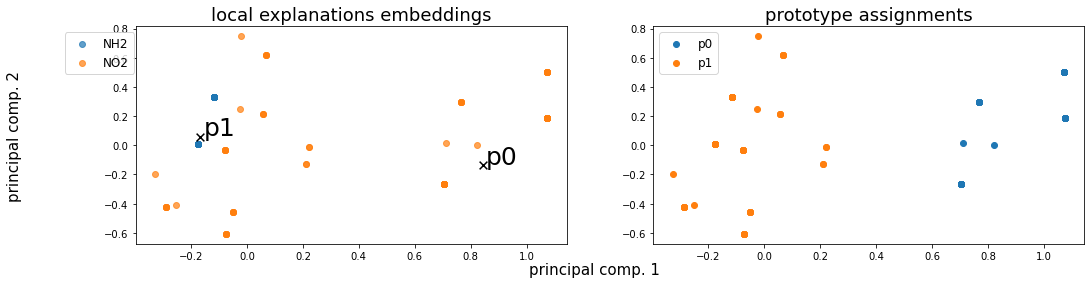

Alpha norms:
tensor([[0.7936, 1.0000],
        [0.8786, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.969889 +- 0.030111
Concept distribution:  (array([0, 1], dtype=int64), array([124, 631], dtype=int64))
Logic formulas:
For class 0:
0.8592057761732852 (feature001) | ((feature000 & feature001)
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.7906)


 80: Loss: 0.02154, LEN: 0.021031, AccxC: 0.86, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.02641, V. LEN 0.02
 81: Loss: 0.02051, LEN: 0.020026, AccxC: 0.86, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.02585, V. LEN 0.02
 82: Loss: 0.02075, LEN: 0.020281, AccxC: 0.86, AccO: 0.80, V. Acc: 0.84, V. Loss: 0.02642, V. LEN 0.02
 83: Loss: 0.02114, LEN: 0.020313, AccxC: 0.86, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.02740, V. LEN 0.02
 84: Loss: 0.02105, LEN: 0.020488, AccxC: 0.86, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.02829, V. LEN 0.02
 85: Loss: 0.02030, LEN: 0.019836, AccxC: 0.86, AccO: 0.80, V. Acc: 0.84, V. Loss: 0.02765, V. LEN

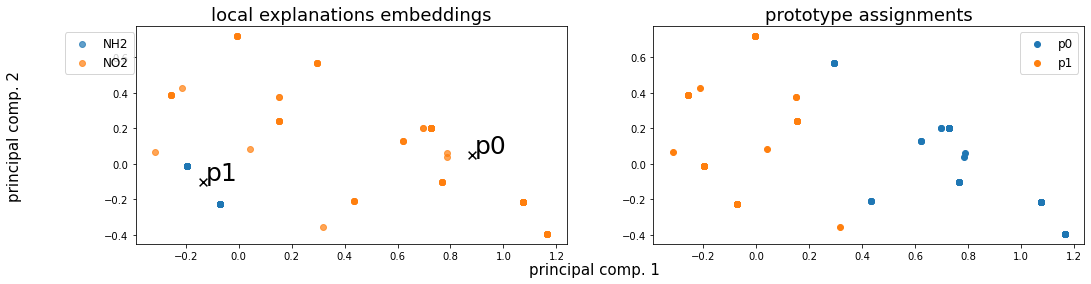

Alpha norms:
tensor([[0.8396, 1.0000],
        [1.0000, 0.8021]], grad_fn=<DivBackward0>)
Concept Purity: 0.980551 +- 0.019449
Concept distribution:  (array([0, 1], dtype=int64), array([138, 617], dtype=int64))
Logic formulas:
For class 0:
0.871841155234657 (feature001) | ((feature000 & feature001)
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.7888)


100: Loss: 0.01862, LEN: 0.018275, AccxC: 0.87, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.02094, V. LEN 0.02
101: Loss: 0.01969, LEN: 0.019418, AccxC: 0.86, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.02437, V. LEN 0.02
102: Loss: 0.01930, LEN: 0.018746, AccxC: 0.87, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.02501, V. LEN 0.02
103: Loss: 0.01995, LEN: 0.019482, AccxC: 0.87, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.02408, V. LEN 0.02
104: Loss: 0.01925, LEN: 0.018736, AccxC: 0.87, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.02428, V. LEN 0.02
105: Loss: 0.01852, LEN: 0.017877, AccxC: 0.87, AccO: 0.79, V. Acc: 0.84, V. Loss: 0.02131, V. LEN 

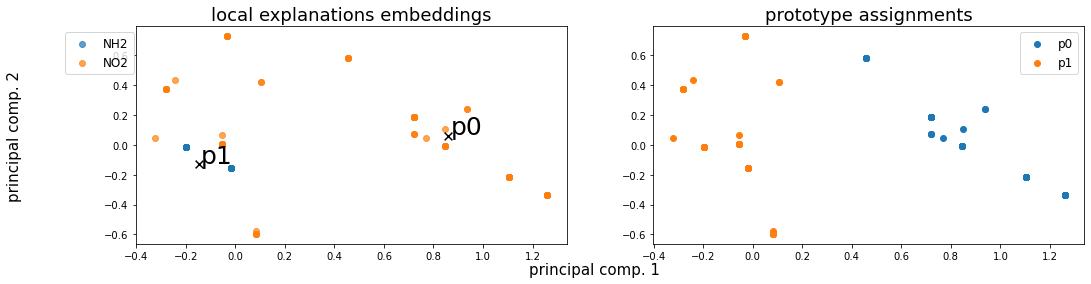

Alpha norms:
tensor([[0.8854, 1.0000],
        [1.0000, 0.6436]], grad_fn=<DivBackward0>)
Concept Purity: 0.977456 +- 0.022544
Concept distribution:  (array([0, 1], dtype=int64), array([134, 621], dtype=int64))
Logic formulas:
For class 0:
0.871841155234657 (feature001) | ((feature000 & feature001)
For class 1:
0.871841155234657 (feature000)
Accuracy as classifier:  0.8718
LEN fidelity:  tensor(0.8718)


120: Loss: 0.01968, LEN: 0.018394, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01888, V. LEN 0.02
121: Loss: 0.01748, LEN: 0.017244, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01803, V. LEN 0.02
122: Loss: 0.01915, LEN: 0.018787, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01740, V. LEN 0.02
123: Loss: 0.02078, LEN: 0.020357, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01790, V. LEN 0.02
124: Loss: 0.01867, LEN: 0.018308, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01804, V. LEN 0.02
125: Loss: 0.01864, LEN: 0.018169, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93

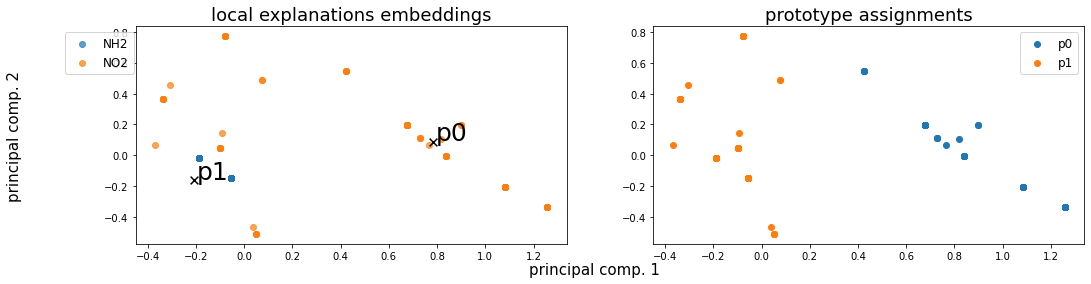

Alpha norms:
tensor([[0.9668, 1.0000],
        [1.0000, 0.5845]], grad_fn=<DivBackward0>)
Concept Purity: 0.977456 +- 0.022544
Concept distribution:  (array([0, 1], dtype=int64), array([134, 621], dtype=int64))
Logic formulas:
For class 0:
0.871841155234657 (feature001) | ((feature000 & feature001)
For class 1:
0.871841155234657 (feature000)
Accuracy as classifier:  0.8718
LEN fidelity:  tensor(0.8718)


140: Loss: 0.01743, LEN: 0.017125, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01825, V. LEN 0.02
141: Loss: 0.01774, LEN: 0.017495, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01835, V. LEN 0.02
142: Loss: 0.01994, LEN: 0.019647, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01845, V. LEN 0.02
143: Loss: 0.01889, LEN: 0.018526, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01850, V. LEN 0.02
144: Loss: 0.01878, LEN: 0.018441, AccxC: 0.88, AccO: 0.88, V. Acc: 0.93, V. Loss: 0.01860, V. LEN 0.02
145: Loss: 0.01763, LEN: 0.017329, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93

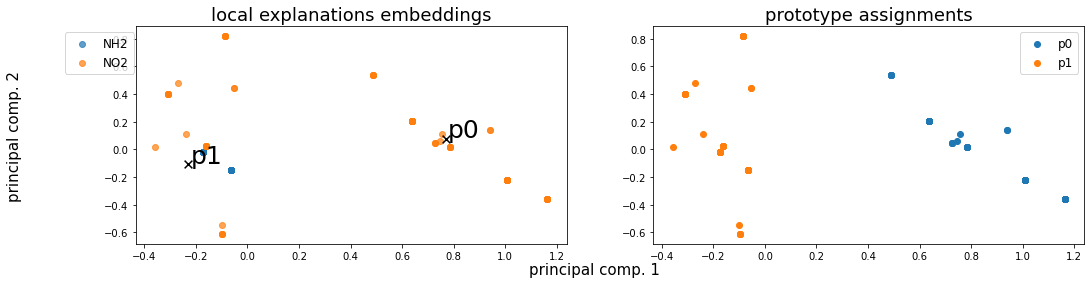

Alpha norms:
tensor([[1.0000, 0.9763],
        [1.0000, 0.5616]], grad_fn=<DivBackward0>)
Concept Purity: 0.977456 +- 0.022544
Concept distribution:  (array([0, 1], dtype=int64), array([134, 621], dtype=int64))
Logic formulas:
For class 0:
0.871841155234657 ((feature001) | ((feature001 & feature000)
For class 1:
0.871841155234657 (feature000)
Accuracy as classifier:  0.8718
LEN fidelity:  tensor(0.8718)


160: Loss: 0.01750, LEN: 0.016748, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01766, V. LEN 0.02
161: Loss: 0.01776, LEN: 0.017400, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01795, V. LEN 0.02
162: Loss: 0.01809, LEN: 0.017716, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01828, V. LEN 0.02
163: Loss: 0.01750, LEN: 0.017312, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01786, V. LEN 0.02
164: Loss: 0.01757, LEN: 0.017301, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01780, V. LEN 0.02
165: Loss: 0.01764, LEN: 0.017472, AccxC: 0.87, AccO: 0.87, V. Acc: 0.9

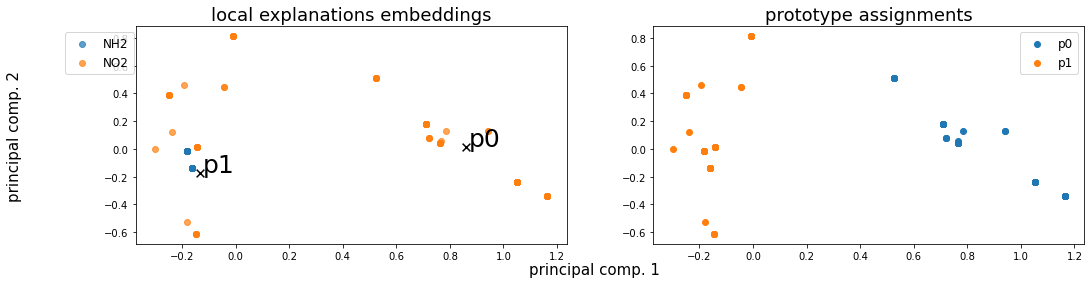

Alpha norms:
tensor([[1.0000, 0.9068],
        [1.0000, 0.5407]], grad_fn=<DivBackward0>)
Concept Purity: 0.977456 +- 0.022544
Concept distribution:  (array([0, 1], dtype=int64), array([134, 621], dtype=int64))
Logic formulas:
For class 0:
0.871841155234657 ((feature001) | ((feature001 & feature000)
For class 1:
0.871841155234657 (feature000)
Accuracy as classifier:  0.8718
LEN fidelity:  tensor(0.8718)


180: Loss: 0.01792, LEN: 0.017735, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01816, V. LEN 0.02
181: Loss: 0.01726, LEN: 0.017065, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01776, V. LEN 0.02
182: Loss: 0.01745, LEN: 0.017230, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01763, V. LEN 0.02
183: Loss: 0.01821, LEN: 0.017943, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01745, V. LEN 0.02
184: Loss: 0.01850, LEN: 0.018245, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01709, V. LEN 0.02
185: Loss: 0.02130, LEN: 0.017664, AccxC: 0.87, AccO: 0.87, V. Acc: 0.9

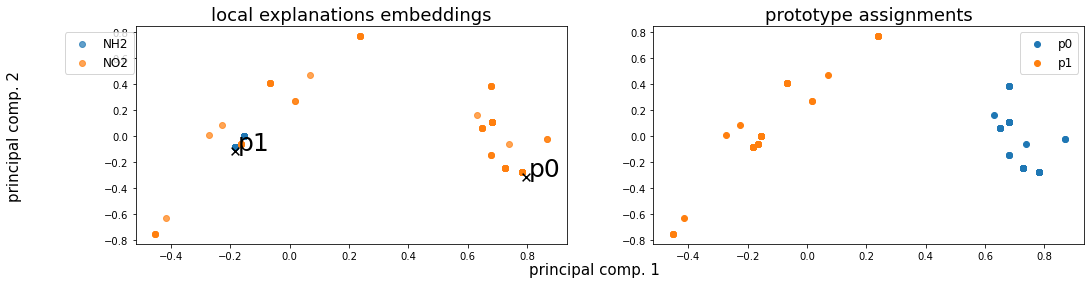

Alpha norms:
tensor([[1.0000, 0.8699],
        [1.0000, 0.5229]], grad_fn=<DivBackward0>)
Concept Purity: 0.977456 +- 0.022544
Concept distribution:  (array([0, 1], dtype=int64), array([134, 621], dtype=int64))
Logic formulas:
For class 0:
0.871841155234657 ((feature001) | ((feature001 & feature000)
For class 1:
0.871841155234657 (feature000)
Accuracy as classifier:  0.8718
LEN fidelity:  tensor(0.8718)


200: Loss: 0.01786, LEN: 0.017365, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01697, V. LEN 0.02
201: Loss: 0.01926, LEN: 0.018883, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01702, V. LEN 0.02
202: Loss: 0.01869, LEN: 0.018107, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01709, V. LEN 0.02
203: Loss: 0.01845, LEN: 0.017076, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01720, V. LEN 0.02
204: Loss: 0.01942, LEN: 0.018877, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01780, V. LEN 0.02
205: Loss: 0.01853, LEN: 0.018173, AccxC: 0.87, AccO: 0.87, V. Acc: 0.9

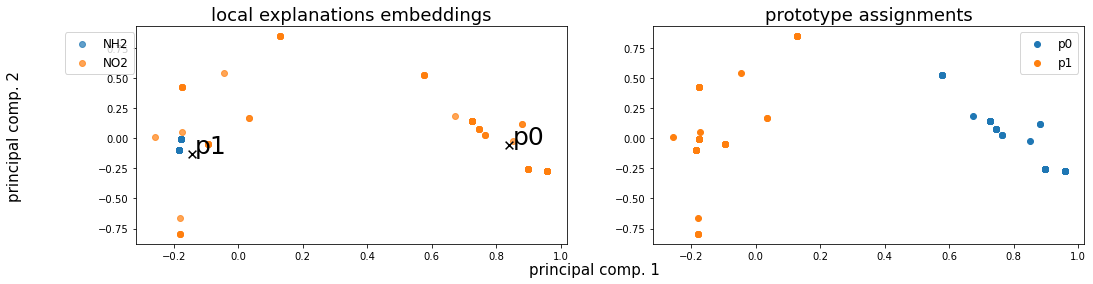

Alpha norms:
tensor([[1.0000, 0.8454],
        [1.0000, 0.5142]], grad_fn=<DivBackward0>)
Concept Purity: 0.977456 +- 0.022544
Concept distribution:  (array([0, 1], dtype=int64), array([134, 621], dtype=int64))
Logic formulas:
For class 0:
0.871841155234657 ((feature001) | ((feature001 & feature000)
For class 1:
0.871841155234657 (feature000)
Accuracy as classifier:  0.8718
LEN fidelity:  tensor(0.8718)


220: Loss: 0.01887, LEN: 0.018568, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01746, V. LEN 0.02
221: Loss: 0.01724, LEN: 0.017007, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01759, V. LEN 0.02
222: Loss: 0.01715, LEN: 0.016893, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01773, V. LEN 0.02
223: Loss: 0.01803, LEN: 0.017844, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01757, V. LEN 0.02
224: Loss: 0.01785, LEN: 0.017652, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01752, V. LEN 0.02
225: Loss: 0.01803, LEN: 0.017807, AccxC: 0.87, AccO: 0.87, V. Acc: 0.9

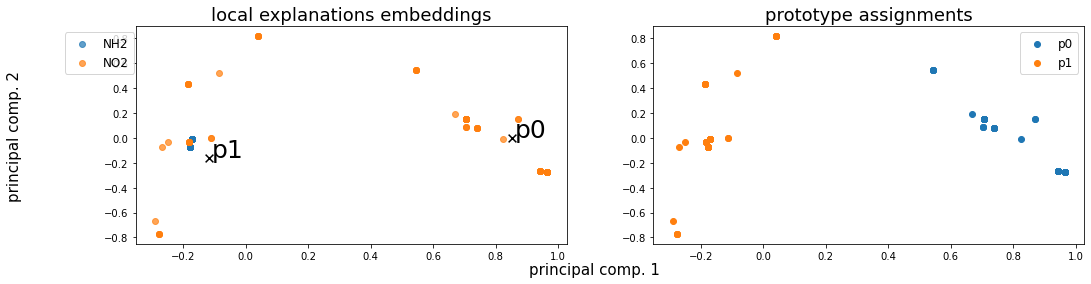

Alpha norms:
tensor([[1.0000, 0.8199],
        [1.0000, 0.5039]], grad_fn=<DivBackward0>)
Concept Purity: 0.977456 +- 0.022544
Concept distribution:  (array([0, 1], dtype=int64), array([134, 621], dtype=int64))
Logic formulas:
For class 0:
0.871841155234657 ((feature001) | ((feature001 & feature000)
For class 1:
0.871841155234657 (feature000)
Accuracy as classifier:  0.8718
LEN fidelity:  tensor(0.8718)


240: Loss: 0.01740, LEN: 0.017231, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01844, V. LEN 0.02
241: Loss: 0.01742, LEN: 0.017190, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01784, V. LEN 0.02
242: Loss: 0.01768, LEN: 0.017520, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01733, V. LEN 0.02
243: Loss: 0.01717, LEN: 0.016964, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01731, V. LEN 0.02
244: Loss: 0.01733, LEN: 0.017187, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01745, V. LEN 0.02
245: Loss: 0.01756, LEN: 0.017398, AccxC: 0.87, AccO: 0.87, V. Acc: 0.9

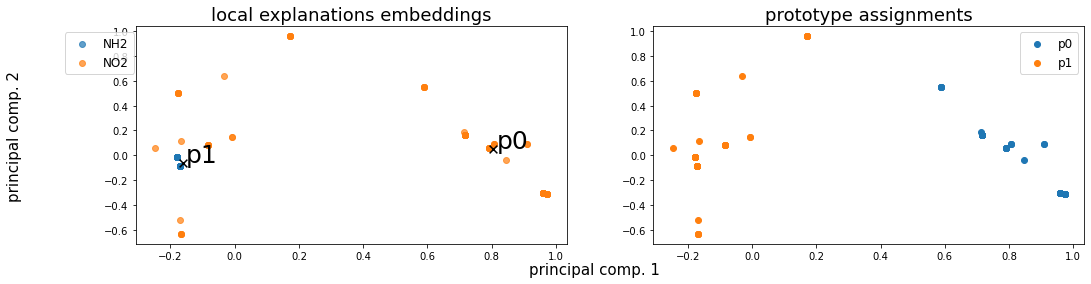

Alpha norms:
tensor([[1.0000, 0.7908],
        [1.0000, 0.4821]], grad_fn=<DivBackward0>)
Concept Purity: 0.977456 +- 0.022544
Concept distribution:  (array([0, 1], dtype=int64), array([134, 621], dtype=int64))
Logic formulas:
For class 0:
0.871841155234657 ((feature001) | ((feature001 & feature000)
For class 1:
0.871841155234657 (feature000)
Accuracy as classifier:  0.8718
LEN fidelity:  tensor(0.8718)


260: Loss: 0.01820, LEN: 0.017984, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01679, V. LEN 0.02
261: Loss: 0.01774, LEN: 0.017539, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01694, V. LEN 0.02
262: Loss: 0.01780, LEN: 0.017614, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01703, V. LEN 0.02
263: Loss: 0.01748, LEN: 0.017242, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01725, V. LEN 0.02
264: Loss: 0.01776, LEN: 0.017575, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01739, V. LEN 0.02
265: Loss: 0.01810, LEN: 0.017921, AccxC: 0.87, AccO: 0.87, V. Acc: 0.9

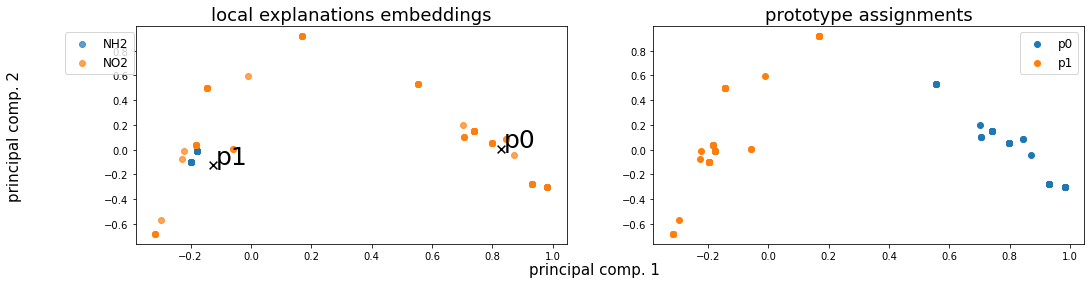

Alpha norms:
tensor([[1.0000, 0.7752],
        [1.0000, 0.4737]], grad_fn=<DivBackward0>)
Concept Purity: 0.977456 +- 0.022544
Concept distribution:  (array([0, 1], dtype=int64), array([134, 621], dtype=int64))
Logic formulas:
For class 0:
0.871841155234657 ((feature001) | ((feature001 & feature000)
For class 1:
0.871841155234657 (feature000)
Accuracy as classifier:  0.8718
LEN fidelity:  tensor(0.8718)


280: Loss: 0.01910, LEN: 0.018865, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01724, V. LEN 0.02
281: Loss: 0.01877, LEN: 0.018560, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01737, V. LEN 0.02
282: Loss: 0.01765, LEN: 0.017410, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01758, V. LEN 0.02
283: Loss: 0.01795, LEN: 0.017765, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01765, V. LEN 0.02
284: Loss: 0.01780, LEN: 0.017643, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01742, V. LEN 0.02
285: Loss: 0.01756, LEN: 0.017357, AccxC: 0.87, AccO: 0.87, V. Acc: 0.9

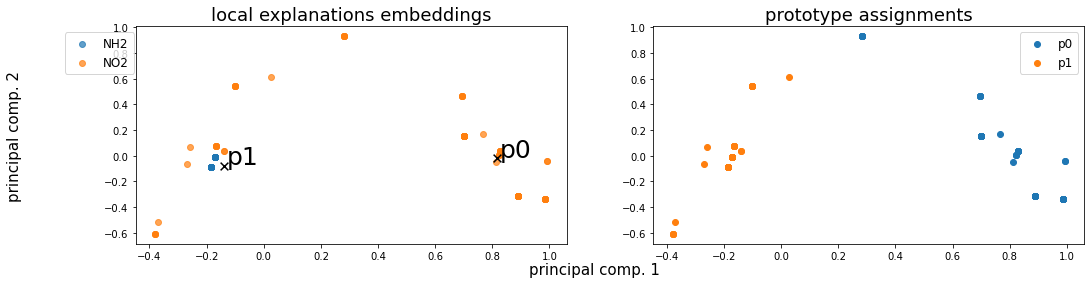

Alpha norms:
tensor([[1.0000, 0.7631],
        [1.0000, 0.4681]], grad_fn=<DivBackward0>)
Concept Purity: 0.982114 +- 0.017886
Concept distribution:  (array([0, 1], dtype=int64), array([140, 615], dtype=int64))
Logic formulas:
For class 0:
0.868231046931408 ((feature001) | ((feature001 & feature000)
For class 1:
0.868231046931408 (feature000)
Accuracy as classifier:  0.8682
LEN fidelity:  tensor(0.8682)


300: Loss: 0.01671, LEN: 0.016517, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01769, V. LEN 0.02
301: Loss: 0.01773, LEN: 0.017559, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01757, V. LEN 0.02
302: Loss: 0.01718, LEN: 0.017039, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01755, V. LEN 0.02
303: Loss: 0.01888, LEN: 0.018474, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01806, V. LEN 0.02
304: Loss: 0.01815, LEN: 0.017760, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01969, V. LEN 0.02
305: Loss: 0.01824, LEN: 0.018077, AccxC: 0.86, AccO: 0.86, V. Acc: 0.9

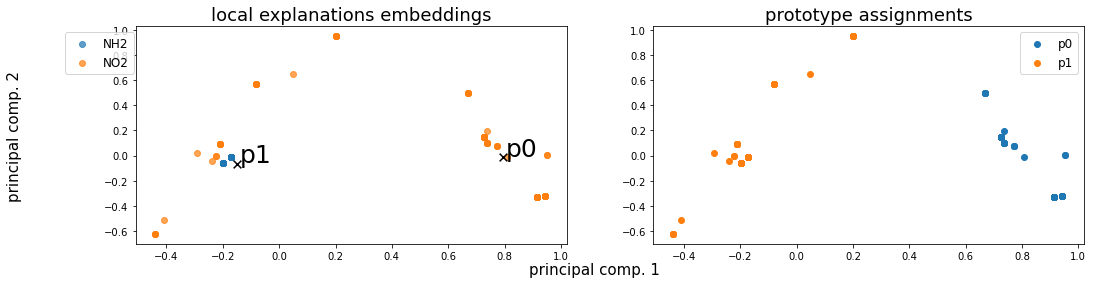

Alpha norms:
tensor([[1.0000, 0.7627],
        [1.0000, 0.4558]], grad_fn=<DivBackward0>)
Concept Purity: 0.977456 +- 0.022544
Concept distribution:  (array([0, 1], dtype=int64), array([134, 621], dtype=int64))
Logic formulas:
For class 0:
0.871841155234657 ((feature001) | ((feature001 & feature000)
For class 1:
0.871841155234657 (feature000)
Accuracy as classifier:  0.8718
LEN fidelity:  tensor(0.8718)


320: Loss: 0.01697, LEN: 0.016826, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01720, V. LEN 0.02
321: Loss: 0.01814, LEN: 0.017979, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01683, V. LEN 0.02
322: Loss: 0.01732, LEN: 0.017154, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01674, V. LEN 0.02
323: Loss: 0.01776, LEN: 0.017601, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01676, V. LEN 0.02
324: Loss: 0.01819, LEN: 0.017877, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01680, V. LEN 0.02
325: Loss: 0.01798, LEN: 0.017843, AccxC: 0.87, AccO: 0.87, V. Acc: 0.9

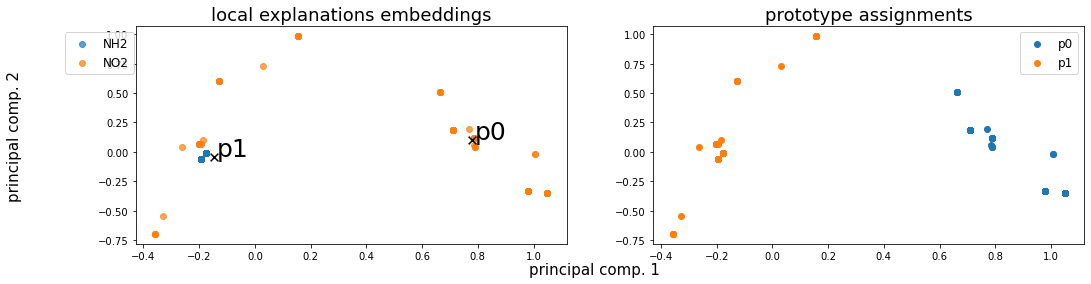

Alpha norms:
tensor([[1.0000, 0.7565],
        [1.0000, 0.4507]], grad_fn=<DivBackward0>)
Concept Purity: 0.977456 +- 0.022544
Concept distribution:  (array([0, 1], dtype=int64), array([134, 621], dtype=int64))
Logic formulas:
For class 0:
0.871841155234657 ((feature001) | ((feature001 & feature000)
For class 1:
0.871841155234657 (feature000)
Accuracy as classifier:  0.8718
LEN fidelity:  tensor(0.8718)


340: Loss: 0.01705, LEN: 0.016880, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01688, V. LEN 0.02
341: Loss: 0.01750, LEN: 0.017350, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01680, V. LEN 0.02
342: Loss: 0.01721, LEN: 0.016993, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01745, V. LEN 0.02
343: Loss: 0.01834, LEN: 0.018186, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01817, V. LEN 0.02
344: Loss: 0.01777, LEN: 0.017547, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01842, V. LEN 0.02
345: Loss: 0.01830, LEN: 0.018125, AccxC: 0.87, AccO: 0.87, V. Acc: 0.9

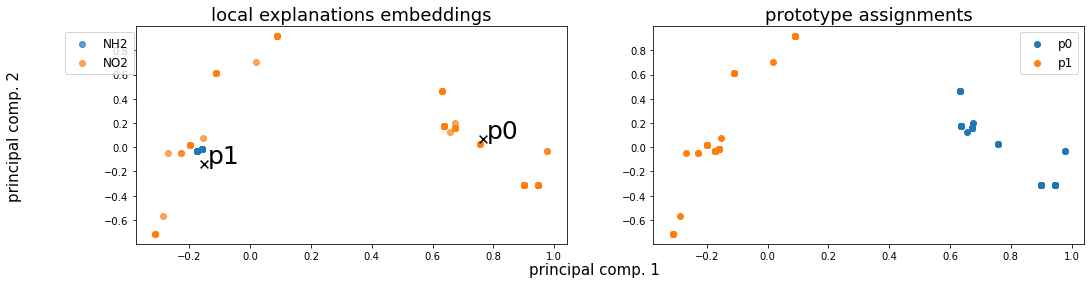

Alpha norms:
tensor([[1.0000, 0.7506],
        [1.0000, 0.4538]], grad_fn=<DivBackward0>)
Concept Purity: 0.977456 +- 0.022544
Concept distribution:  (array([0, 1], dtype=int64), array([134, 621], dtype=int64))
Logic formulas:
For class 0:
0.871841155234657 ((feature001) | ((feature001 & feature000)
For class 1:
0.871841155234657 (feature000)
Accuracy as classifier:  0.8718
LEN fidelity:  tensor(0.8718)


360: Loss: 0.01717, LEN: 0.016997, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01725, V. LEN 0.02
361: Loss: 0.01780, LEN: 0.017630, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01706, V. LEN 0.02
362: Loss: 0.01796, LEN: 0.017789, AccxC: 0.87, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.01694, V. LEN 0.02
363: Loss: 0.01741, LEN: 0.017088, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01750, V. LEN 0.02
364: Loss: 0.01770, LEN: 0.017554, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01749, V. LEN 0.02
365: Loss: 0.01753, LEN: 0.017362, AccxC: 0.87, AccO: 0.87, V. Acc: 0.9

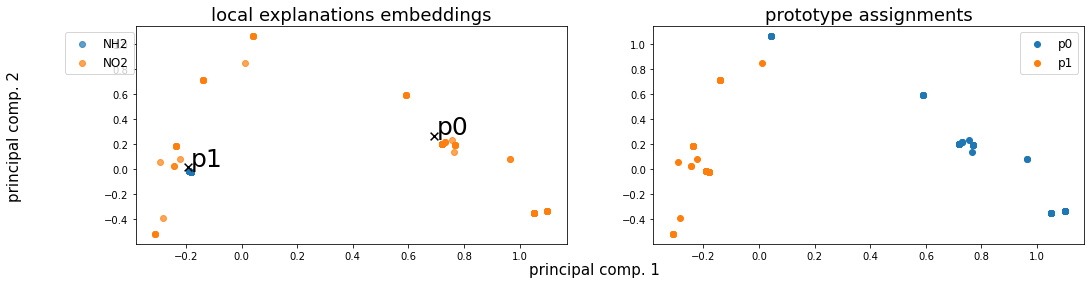

Alpha norms:
tensor([[1.0000, 0.7461],
        [1.0000, 0.4524]], grad_fn=<DivBackward0>)
Concept Purity: 0.982114 +- 0.017886
Concept distribution:  (array([0, 1], dtype=int64), array([140, 615], dtype=int64))
Logic formulas:
For class 0:
0.868231046931408 ((feature001) | ((feature001 & feature000)
For class 1:
0.868231046931408 (feature000)
Accuracy as classifier:  0.8682
LEN fidelity:  tensor(0.8682)


380: Loss: 0.01787, LEN: 0.017522, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01762, V. LEN 0.02
381: Loss: 0.01844, LEN: 0.018108, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01755, V. LEN 0.02
382: Loss: 0.01850, LEN: 0.018240, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01752, V. LEN 0.02
383: Loss: 0.01863, LEN: 0.018395, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01793, V. LEN 0.02
384: Loss: 0.01913, LEN: 0.018869, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01838, V. LEN 0.02
385: Loss: 0.01742, LEN: 0.017196, AccxC: 0.87, AccO: 0.87, V. Acc: 0.9

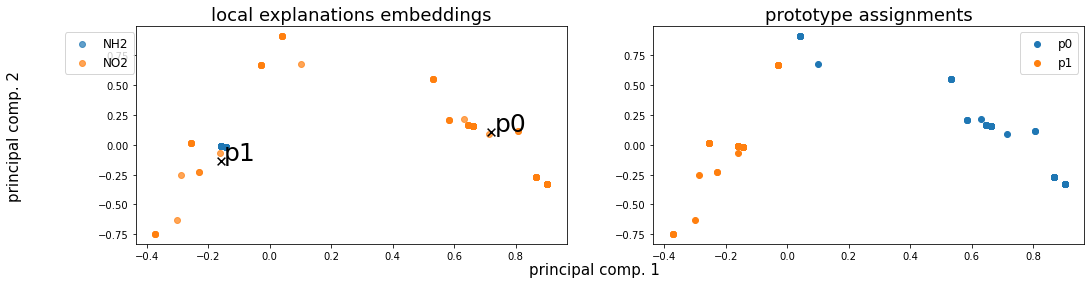

Alpha norms:
tensor([[1.0000, 0.7428],
        [1.0000, 0.4551]], grad_fn=<DivBackward0>)
Concept Purity: 0.982899 +- 0.017101
Concept distribution:  (array([0, 1], dtype=int64), array([141, 614], dtype=int64))
Logic formulas:
For class 0:
0.868231046931408 ((feature001) | ((feature001 & feature000)
For class 1:
0.868231046931408 (feature000)
Accuracy as classifier:  0.8682
LEN fidelity:  tensor(0.8682)


400: Loss: 0.01746, LEN: 0.017317, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01814, V. LEN 0.02
401: Loss: 0.01818, LEN: 0.018003, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01765, V. LEN 0.02
402: Loss: 0.01831, LEN: 0.018128, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01740, V. LEN 0.02
403: Loss: 0.01774, LEN: 0.017393, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01774, V. LEN 0.02
404: Loss: 0.01665, LEN: 0.016390, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01762, V. LEN 0.02
405: Loss: 0.01774, LEN: 0.017473, AccxC: 0.87, AccO: 0.87, V. Acc: 0.9

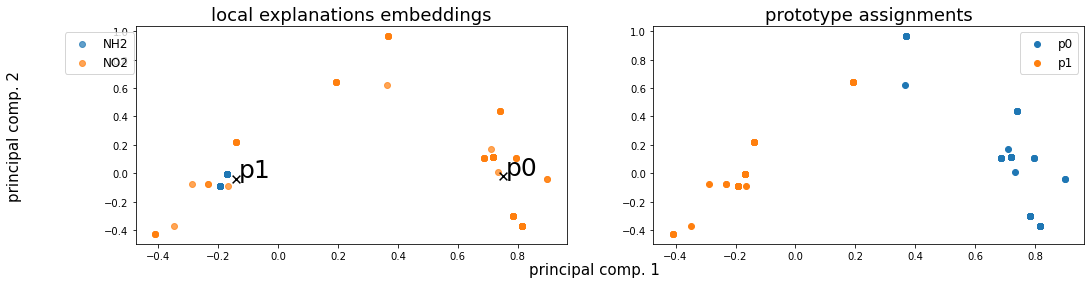

Alpha norms:
tensor([[1.0000, 0.7401],
        [1.0000, 0.4608]], grad_fn=<DivBackward0>)
Concept Purity: 0.982899 +- 0.017101
Concept distribution:  (array([0, 1], dtype=int64), array([141, 614], dtype=int64))
Logic formulas:
For class 0:
0.868231046931408 ((feature001) | ((feature001 & feature000)
For class 1:
0.868231046931408 (feature000)
Accuracy as classifier:  0.8682
LEN fidelity:  tensor(0.8682)


420: Loss: 0.01772, LEN: 0.017560, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01820, V. LEN 0.02
421: Loss: 0.01759, LEN: 0.017431, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01765, V. LEN 0.02
422: Loss: 0.01806, LEN: 0.017926, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01740, V. LEN 0.02
423: Loss: 0.01765, LEN: 0.017472, AccxC: 0.87, AccO: 0.87, V. Acc: 0.91, V. Loss: 0.01736, V. LEN 0.02
424: Loss: 0.01758, LEN: 0.017392, AccxC: 0.86, AccO: 0.86, V. Acc: 0.91, V. Loss: 0.01759, V. LEN 0.02
425: Loss: 0.01728, LEN: 0.017177, AccxC: 0.87, AccO: 0.87, V. Acc: 0.9

In [58]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 3, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 2,
    "dim_prototypes": 10,
    "num_le_features": 14,
    "backbone": "GIN",
    "backbone_num_layers": 2,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": True,
    "num_epochs": 2000
}

len_model    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 backbone=hyper["backbone"], 
                                 num_layers=hyper["backbone_num_layers"], 
                                 num_hidden=hyper["dim_prototypes"]).to(device)
expl         = models.GlobalExplainer(len_model, 
                               le_model, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=["NH2"] + mutag_classes_names,
                               dataset_name="Mutagenicity").to(device)
expl.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb="", save_metrics=False, plot=True)

(array([0., 1.], dtype=float32), array([593, 162], dtype=int64))


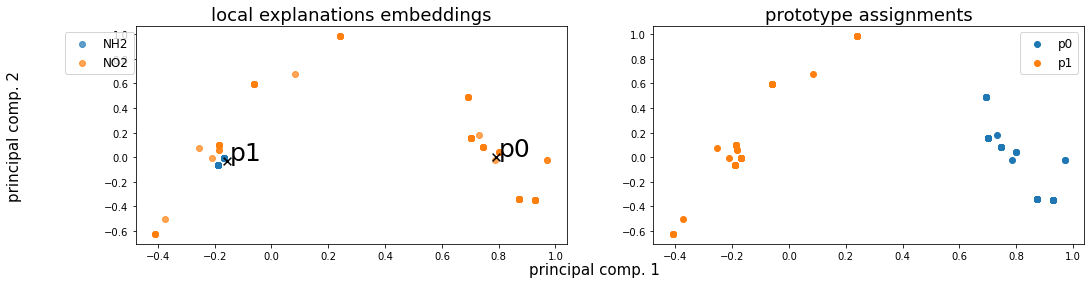

Alpha norms:
tensor([[1.0000, 0.7599],
        [1.0000, 0.4518]], grad_fn=<DivBackward0>)
Concept Purity: 0.977456 +- 0.022544
Concept distribution:  (array([0, 1], dtype=int64), array([134, 621], dtype=int64))
Logic formulas:
For class 0:
0.871841155234657 ((feature001) | ((feature001 & feature000)
For class 1:
0.871841155234657 (feature000)
Accuracy as classifier:  0.8718
LEN fidelity:  tensor(0.8718)



In [59]:
expl.inspect_embedding(train_group_loader)

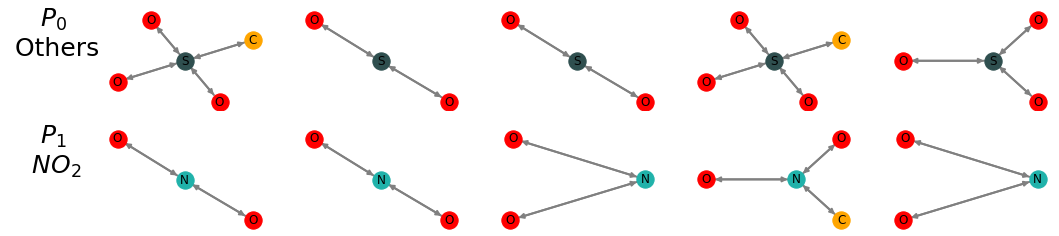

In [60]:
expl.eval()
x_train , emb , concepts_assignement , y_train_1h , le_classes , le_idxs , belonging = expl.get_concept_vector(train_group_loader, 
                                                                                                               return_raw=True)        
proto_names = {
    0: "Others",
    1: "$NO_2$",
}
torch.manual_seed(42)
fig = plt.figure(figsize=(17,4))
n = 0
for p in range(expl.hyper["num_prototypes"]):
    idxs = le_idxs[concepts_assignement.argmax(-1) == p]
    idxs = idxs[torch.randperm(len(idxs))]
    
    for ex in range(5):
        n += 1
        plt.subplot(expl.hyper["num_prototypes"],5,n)        
        #G = to_networkx(dataset_train[int(idx)])
        #nx.draw(G, node_size=50)
        utils.plot_molecule(dataset_train[int(idxs[ex])], composite_plot=True)

for p in range(expl.hyper["num_prototypes"]):
    plt.subplot(expl.hyper["num_prototypes"],5,5*p + 1)
    plt.ylabel(f"$P_{p}$\n {proto_names[p]}", size=25, rotation="horizontal", labelpad=50)
plt.savefig("prototypes_mutagenicity.pdf")
plt.show() 

## Prototype Network

In [9]:
class EarlyStopping():    
    def __init__(self, min_delta = 0, patience = 0):        
        self.min_delta = min_delta
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf
        self.best_epoch = 0
        self.stop_training = False
    
    def on_epoch_end(self, epoch, current_value):
        if np.less((current_value + self.min_delta), self.best):
            self.best = current_value
            self.best_epoch = epoch
            self.wait = 0
        else:
            self.wait += 1
            if self.wait > self.patience:
                self.stopped_epoch = epoch
                self.stop_training = True
        return self.stop_training

In [14]:
class ProtoModel(torch.nn.Module):
    def __init__(self, len_model, le_model, dataloader, val_dataloader, device, hyper_params):
        super().__init__()        
        
        self.le_model = le_model
        self.len_model = len_model
        
        self.decoder = torch.nn.Sequential(*[
            torch.nn.Linear(2, 5),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(5, 2)
        ])
        self.prototype_vectors = torch.nn.Parameter(torch.rand((hyper["num_prototypes"], hyper["dim_prototypes"])), requires_grad=True)
        
        self.dataloader = dataloader
        self.val_dataloader = val_dataloader
        self.device = device
        self.assign_func = hyper["assign_func"]
        self.hyper = hyper
        self.temp = hyper["ts"]
        self.early_stopping = EarlyStopping(min_delta=0, patience=100)
        
        self.optimizer = torch.optim.Adam(le_model.parameters(), lr=0.001)
        self.optimizer.add_param_group({'params': len_model.parameters(), 'lr': 0.0005})
        self.optimizer.add_param_group({'params': self.prototype_vectors, 'lr': 0.001})
        self.optimizer.add_param_group({'params': self.decoder.parameters(), 'lr': 0.0001, 'weight_decay': 1e-2})
        
        if hyper["focal_loss"]:
            self.loss_len = utils.focal_loss
        else:
            self.loss_len = utils.BCEWithLogitsLoss        
        
    def get_concept_vector(self, loader, return_raw=False):
        le_embeddings = torch.tensor([], device=self.device)
        new_belonging = torch.tensor([], device=self.device, dtype=torch.long)
        y = torch.tensor([], device=self.device)
        le_classes = torch.tensor([], device=self.device)
        le_idxs = torch.tensor([], device=self.device)
        for data in loader:
            data = data.to(self.device)
            le_idxs = torch.concat([le_idxs, data.le_id], dim=0)
            embs = self.le_model(data.x, data.edge_index, data.batch)
            le_embeddings = torch.concat([le_embeddings, embs], dim=0)
            new_belonging = torch.concat([new_belonging, data.graph_id], dim=0)
            le_classes = torch.concat([le_classes, data.y], dim=0)
            y = torch.concat([y, data.task_y], dim=0)
            
        y = scatter(y, new_belonging, dim=0, reduce="max")
        y = torch.nn.functional.one_hot(y.long()).float().to(device)
             
        le_assignments = utils.prototype_assignement(self.hyper["assign_func"], le_embeddings, self.prototype_vectors, temp=1)        
        concept_vector = scatter(le_assignments, new_belonging, dim=0, reduce="max")  #"sum"
        #concept_vector = torch.clip(concept_vector, min=0, max=1)
        if return_raw:
            return concept_vector , le_embeddings ,  le_assignments , y , le_classes.cpu() , le_idxs , new_belonging
        else:
            return concept_vector , le_embeddings

    
    def train_epoch(self, loader, epoch, log_wandb=False, train=True):   
        if train:
            self.le_model.train()
            self.len_model.train()
            self.decoder.train()
        else:
            self.le_model.eval()
            self.len_model.eval()
            self.decoder.eval()
            

        total_loss                    = torch.tensor(0., device=self.device)
        total_recontr_loss            = torch.tensor(0., device=self.device)
        total_prototype_distance_loss = torch.tensor(0., device=self.device)
        total_r1_loss                 = torch.tensor(0., device=self.device)
        total_r2_loss                 = torch.tensor(0., device=self.device)
        total_concept_entropy_loss    = torch.tensor(0., device=self.device)
        total_div_loss                = torch.tensor(0., device=self.device)
        total_len_loss                = torch.tensor(0., device=self.device)
        total_debug_loss              = torch.tensor(0., device=self.device)
        total_logic_loss              = torch.tensor(0., device=self.device)
        
        preds , trues = torch.tensor([], device=self.device) , torch.tensor([], device=self.device)
        le_classes = torch.tensor([], device=self.device)
        total_prototype_assignements = torch.tensor([], device=self.device)
        for data in loader:
            self.optimizer.zero_grad() 
            data = data.to(self.device)
            le_embeddings = self.le_model(data.x, data.edge_index, data.batch)
            
            new_belonging = torch.tensor(normalize_belonging(data.graph_id), dtype=torch.long, device=self.device)
            y = scatter(data.task_y, new_belonging, dim=0, reduce="max")
            #y2 = scatter(data.task_y, new_belonging, dim=0, reduce="min")
            #assert torch.all(y == y2)
            y_train_1h = torch.nn.functional.one_hot(y.long(), num_classes=2).float().to(device)
            
            prototype_assignements = utils.prototype_assignement(self.hyper["assign_func"], le_embeddings, self.prototype_vectors, temp=1)
#             prototype_assignements_new = torch.zeros_like(prototype_assignements)
#             prototype_assignements_new[:, prototype_assignements.argmax(1)] += 1
#             prototype_assignements = prototype_assignements_new

            total_prototype_assignements = torch.cat([total_prototype_assignements, prototype_assignements], dim=0)
            le_classes = torch.concat([le_classes, data.y], dim=0)
            concept_vector = scatter(prototype_assignements, new_belonging, dim=0, reduce="max")  #"sum"
            #concept_vector = torch.clip(concept_vector, min=0, max=1)
            
            if self.hyper["debug_prototypes"]:
                # debug of Prototypes: do classification on prototypes
                loss , r1_loss , r2_loss , div_loss , debug_loss = self.debug_prototypes(le_embeddings, prototype_assignements, data.y, train)
                total_loss += loss.detach()
                total_r1_loss += r1_loss.detach()
                total_r2_loss += r2_loss.detach()
                total_div_loss += div_loss.detach()
                total_debug_loss += debug_loss.detach()
                preds = torch.cat([preds, prototype_assignements], dim=0)
                trues = torch.cat([trues, data.y], dim=0)
                continue
                
            # LEN
            y_pred = self.len_model(concept_vector).squeeze(-1)
            preds = torch.cat([preds, y_pred], dim=0)
            trues = torch.cat([trues, y_train_1h], dim=0)
            len_loss = 0.5 * self.loss_len(y_pred, y_train_1h, self.hyper["focal_gamma"], self.hyper["focal_alpha"])  #0 * F.cross_entropy(prototype_assignements, data.y) + 
            #logic_loss = self.hyper["coeff_logic_loss"] * te.nn.functional.entropy_logic_loss(self.len_model)
            logic_loss = torch.tensor(0., device=self.device)
            
            # GAE on the LE embeddings
            if self.hyper["coeff_gae"] > 0:
                recontr = self.decoder(le_embeddings) 
                recontr_loss = self.hyper["coeff_gae"] * F.l1_loss(recontr, le_embeddings)
            else:
                recontr_loss = torch.tensor(0., device=self.device)
            
            # Prototype distance: push away the different prototypes by maximizing the distance to the nearest prototype
            if self.hyper["coeff_pdist"] > 0:
                prototype_distances = torch.clip(utils.pairwise_dist(self.prototype_vectors), max=0.5).fill_diagonal_(float("inf"))
                prototype_distances = prototype_distances.min(-1).values
                prototype_distance_loss = self.hyper["coeff_pdist"] * - torch.mean(prototype_distances)
            else:
                prototype_distance_loss = torch.tensor(0., device=self.device)
                
            # Div loss: from ProtGNN minimize the cosine similarity between prototypes with some margin
            if self.hyper["coeff_divloss"] > 0:
                proto_norm = F.normalize(self.prototype_vectors, p=2, dim=1)
                cos_distances = torch.mm(proto_norm, torch.t(proto_norm)) - torch.eye(proto_norm.shape[0]).to(self.device) - 0.2
                matrix2 = torch.zeros(cos_distances.shape).to(self.device)
                div_loss = self.hyper["coeff_divloss"] * torch.sum(torch.where(cos_distances > 0, cos_distances, matrix2))   
#                 scal_dot_product = torch.mm(self.prototype_vectors, torch.t(self.prototype_vectors)).fill_diagonal_(0.) / (self.prototype_vectors.shape[1]**0.5)
#                 matrix2 = torch.zeros(scal_dot_product.shape).to(self.device)
#                 div_loss = self.hyper["coeff_divloss"] * torch.sum(torch.where(scal_dot_product > 0, scal_dot_product, matrix2))   
            else:
                div_loss = torch.tensor(0., device=self.device)

            # R1 loss: push each prototype to be close to at least one example
            if self.hyper["coeff_r1"] > 0:
                sample_prototype_distance = torch.cdist(le_embeddings, self.prototype_vectors, p=2)**2 # num_sample x num_prototypes
                min_prototype_sample_distance = sample_prototype_distance.T.min(-1).values
                avg_prototype_sample_distance = torch.mean(min_prototype_sample_distance)
                r1_loss = self.hyper["coeff_r1"] * avg_prototype_sample_distance
            else:
                r1_loss = torch.tensor(0., device=self.device)

            # Prototype closeness loss (R2): Push every example to be close to a sample (From ProtoNet)        
            if self.hyper["coeff_r2"] > 0:
                sample_prototype_distance = torch.cdist(le_embeddings, self.prototype_vectors, p=2)**2
                min_sample_prototype_distance = sample_prototype_distance.min(-1).values
                avg_sample_prototype_distance = torch.mean(min_sample_prototype_distance)
                r2_loss = self.hyper["coeff_r2"] * avg_sample_prototype_distance
            else:
                r2_loss = torch.tensor(0., device=self.device)

            # Entropy losses
            if self.hyper["coeff_ce"] > 0:
                concept_entropy_loss = self.hyper["coeff_ce"] * utils.entropy_loss(prototype_assignements)
            else:
                concept_entropy_loss = torch.tensor(0., device=self.device)
                
            if self.hyper["coeff_de"] > 0:
                distribution_entropy_loss = self.hyper["coeff_de"] * utils.entropy_loss(
                    torch.nn.functional.normalize(
                        torch.sum(prototype_assignements, dim=0),
                        p=2.0, dim=0).unsqueeze(0)
                )       
            else:
                distribution_entropy_loss = torch.tensor(0., device=self.device)


            loss = len_loss + logic_loss + recontr_loss  + prototype_distance_loss + r1_loss + r2_loss + concept_entropy_loss + div_loss
            total_loss                    += loss.detach()
            total_len_loss                += len_loss.detach()
            total_recontr_loss            += recontr_loss.detach()
            total_prototype_distance_loss += prototype_distance_loss.detach()
            total_r1_loss                 += r1_loss.detach()
            total_r2_loss                 += r2_loss.detach()
            total_concept_entropy_loss    += concept_entropy_loss.detach()
            total_div_loss                += div_loss.detach()
            total_logic_loss              += logic_loss.detach()
            
            if train:
                loss.backward()
                self.optimizer.step()      
        
        if self.hyper["debug_prototypes"]:
            acc = accuracy_score(trues.cpu(), preds.argmax(-1).cpu())
        else:
            acc = accuracy_score(trues.argmax(-1).cpu(), preds.argmax(-1).cpu())
            acc_overall = sum(trues[:, :].eq(preds[:, :] > 0).sum(1) == 2) / len(preds)
            
        metrics = {'loss': total_loss.item()/len(loader), 
                    "acc": acc, 
                    "accO": acc_overall, 
                    "len_loss": total_len_loss.item()/len(loader),
                    "logic_loss": total_logic_loss.item()/len(loader),
                    "gae_loss": total_recontr_loss.item()/len(loader),
                    "prototype_distance_loss": total_prototype_distance_loss.item()/len(loader),
                    "r1_loss": total_r1_loss.item()/len(loader),
                    "r2_loss": total_r2_loss.item()/len(loader),
                    "div_loss": total_div_loss.item()/len(loader),
                    "debug_loss": total_debug_loss.item()/len(loader),
                    "concept_entropy_loss": total_concept_entropy_loss.item()/len(loader),
                    "temperature": self.temp,
                    "cluster acc": np.mean(self.get_cluster_accuracy(total_prototype_assignements.argmax(1).detach().cpu().numpy(), le_classes.cpu())),
                    "Proto norm": torch.mean(torch.norm(self.prototype_vectors, p=2, dim=-1))
                  }
        if log_wandb:
            k = "train" if train else "val"
            self.log({k: metrics}) 
        return metrics
        

    def debug_prototypes(self, le_embeddings, prototype_assignements, y, train=True):
        coeff_r1 = 0.9
        coeff_r2 = 0. #0.09
        coeff_div = 0.

        debug_loss = 1 * F.cross_entropy(prototype_assignements, y)

        sample_prototype_distance = torch.cdist(le_embeddings, self.prototype_vectors, p=2)**2 # num_sample x num_prototypes
        min_prototype_sample_distance = sample_prototype_distance.T.min(-1).values
        avg_prototype_sample_distance = torch.mean(min_prototype_sample_distance)
        r1_loss = self.hyper["coeff_r1"] * avg_prototype_sample_distance     

        min_sample_prototype_distance = sample_prototype_distance.min(-1).values
        avg_sample_prototype_distance = torch.mean(min_sample_prototype_distance)
        r2_loss = self.hyper["coeff_r2"] * avg_sample_prototype_distance

#         proto_norm = F.normalize(self.prototype_vectors, p=2, dim=1)
#         cos_distances = torch.mm(proto_norm, torch.t(proto_norm)) - torch.eye(proto_norm.shape[0]).to(self.device) - 0.2
#         matrix2 = torch.zeros(cos_distances.shape).to(self.device)
#         div_loss = self.hyper["coeff_divloss"] * torch.sum(torch.where(cos_distances > 0, cos_distances, matrix2))   
        div_loss = torch.tensor(0., device=r2_loss.device)

        loss = debug_loss +  r1_loss + r2_loss + div_loss
        
        if train:
            loss.backward()
            self.optimizer.step()
        return loss, r1_loss , r2_loss , div_loss , debug_loss
        
        
    def iterate(self, num_epochs, log_wandb=False, name_wandb=""):
        if log_wandb:
            self.run = wandb.init(
                    project='GlobalGraphXAI',
                    name=name_wandb,
                    entity='mcstewe',
                    reinit=True,
                    save_code=False,
                    config=self.hyper
            )
            wandb.watch(self.le_model)
            wandb.watch(self.len_model)        
        
        for epoch in range(1, num_epochs):
            train_metrics = self.train_epoch(self.dataloader, epoch, log_wandb)
            val_metrics   = self.train_epoch(self.val_dataloader, epoch, log_wandb, train=False)
            
            if epoch % 10 == 0:
                self.inspect_embedding(self.dataloader, log_wandb)
            
            self.temp -= (self.hyper["ts"] - self.hyper["te"]) / num_epochs
            if log_wandb and self.hyper["log_models"]:
                torch.save(self.state_dict(), f"{wandb.run.dir}/epoch_{epoch}.pt")                
            
            print(f'{epoch:3d}: Loss: {train_metrics["loss"]:.5f}, LEN: {train_metrics["len_loss"]:2f}, Debug: {train_metrics["debug_loss"]:.4f}, Tr. Acc: {train_metrics["acc"]:.2f}, Tr. AccO: {train_metrics["accO"]:.2f}, V. Acc: {val_metrics["acc"]:.2f}, V. Loss: {val_metrics["loss"]:.5f}, V. LEN {val_metrics["len_loss"]:.2f}')
            
            if self.early_stopping.on_epoch_end(epoch, val_metrics["loss"]):
                print(f"Early Stopping")
                if self.hyper["log_models"]:
                    print(f"Loading model at epoch {self.early_stopping.best_epoch}")
                    path = path = f"{wandb.run.dir}/epoch_{self.early_stopping.best_epoch}.pt"
                    self.load_state_dict(torch.load(path))
                break
        print(f"Best epoch: {self.early_stopping.best_epoch}")   
                
        if log_wandb:
            if self.hyper["log_models"]:
                wandb.save(f'{wandb.run.dir}/epoch_*.pt')
            self.run.finish()            

    
    @torch.no_grad()
    def inspect_embedding(self, loader, log_wandb=False):
        self.le_model.eval()
        self.len_model.eval()
        
        x_train , emb , concepts_assignement , y_train_1h , new_le_classes , le_idxs , new_belonging = self.get_concept_vector(loader, return_raw=True)
        
        y_pred = self.len_model(x_train).squeeze(-1)
        #loss = self.loss_len(y_pred, y_train_1h, self.hyper["focal_gamma"], self.hyper["focal_alpha"])
        #grads = torch.autograd.grad(outputs=loss, inputs=emb, grad_outputs=torch.ones_like(loss))[0].detach().cpu().numpy()
        #grads = np.zeros(emb.shape)
        
        with torch.no_grad():
            emb = emb.detach().cpu().numpy()
            concept_predictions = concepts_assignement.argmax(1).cpu().numpy()
        
            # plot embedding
            pca = PCA(n_components=2, random_state=42)
            emb2d = emb if self.prototype_vectors.shape[1] == 2 else pca.fit_transform(emb) #emb
            plt.figure(figsize=(17,4))
            plt.subplot(1,4,1)
            plt.title("learned graph embedding in 2D")
            print(np.unique(new_le_classes, return_counts=True))
            for c in np.unique(new_le_classes):
                plt.scatter(emb2d[new_le_classes == c,0], emb2d[new_le_classes == c,1])
            proto_2d = self.prototype_vectors.cpu().numpy() if self.prototype_vectors.shape[1] == 2 else pca.transform(self.prototype_vectors.cpu().numpy())
            plt.scatter(proto_2d[:, 0], proto_2d[:,1], marker="x", s=60, c="black")        
            for i, txt in enumerate(range(proto_2d.shape[0])):
                plt.annotate(str(i), (proto_2d[i,0]+0.01, proto_2d[i,1]+0.01))
            plt.subplot(1,4,2)
            plt.title("LENet concept assignments in 2D")
            for c in range(self.prototype_vectors.shape[0]):
                plt.scatter(emb2d[concept_predictions == c,0], emb2d[concept_predictions == c,1])
            plt.subplot(1,4,3)
            plt.title("wrong explanations")
            idx_belonging_correct = y_pred.argmax(1) == y_train_1h.argmax(1)
            idx_belonging_wrong   = y_pred.argmax(1) != y_train_1h.argmax(1)
            colors = []
            for idx in range(emb2d.shape[0]):
                if idx_belonging_correct[new_belonging[idx]]:
                    colors.append("blue")
                elif idx_belonging_wrong[new_belonging[idx]]:
                    colors.append("red")
            plt.scatter(emb2d[:, 0], emb2d[:, 1], c=colors)
            plt.subplot(1,4,4)
            plt.title("CE for local explanation")
            plt.scatter(emb2d[:, 0], emb2d[:, 1], c=utils.entropy_loss(concepts_assignement, return_raw=True).cpu())   #to plot grads
            plt.colorbar()
            if log_wandb: 
                wandb.log({"concepts_assignement": wandb.Histogram(concepts_assignement.detach().cpu()),
                           "concepts_assignement_entropy": utils.entropy_loss(concepts_assignement),
                           "concept_vector": wandb.Histogram(x_train.detach().cpu()),
                           "concept_purity": np.mean(self.get_cluster_accuracy(concept_predictions, new_le_classes))})
                if self.hyper["log_images"]:
                    wandb.log({"plots": wandb.Image(plt)})
            if self.prototype_vectors.shape[1] > 2: print(pca.explained_variance_ratio_)
            plt.show()          


            #log stats
            accs = self.get_cluster_accuracy(concept_predictions, new_le_classes)
            print(f"Concept Purity: {np.mean(accs):2f} +- {np.std(accs):2f}")
            print("Concept distribution: ", np.unique(concept_predictions, return_counts=True))        
            
            if not isinstance(self.len_model[0], te.nn.logic.EntropyLinear) or self.hyper["debug_prototypes"]:
                return
            
            print("Alpha norms:")
            print(self.len_model[0].alpha_norm)
            print("Logic formulas:")
            x_train = x_train.detach()
            print("For class 0:")
            explanation0, explanation_raw, _ = entropy.explain_class(self.len_model.cpu(), x_train.cpu(), y_train_1h.cpu(), train_mask=torch.arange(x_train.shape[0]).long(), val_mask=torch.arange(x_train.shape[0]).long(), target_class=0, max_accuracy=True, topk_explanations=3000, try_all=False)
            accuracy0, preds = test_explanation(explanation0, x_train.cpu(), y_train_1h.cpu(), target_class=0, mask=torch.arange(x_train.shape[0]).long(), material=False)
            print(accuracy0, utils.rewrite_formula_to_close(utils.assemble_raw_explanations(explanation_raw)))

            print("For class 1:")
            explanation1, explanation_raw, _ = entropy.explain_class(self.len_model.cpu(), x_train.cpu(), y_train_1h.cpu(), train_mask=torch.arange(x_train.shape[0]).long(), val_mask=torch.arange(x_train.shape[0]).long(), target_class=1, max_accuracy=True, topk_explanations=3000, try_all=False)
            accuracy1, preds = test_explanation(explanation1, x_train.cpu(), y_train_1h.cpu(), target_class=1, mask=torch.arange(x_train.shape[0]).long(), material=False)
            print(accuracy1, utils.rewrite_formula_to_close(utils.assemble_raw_explanations(explanation_raw)))
            
            accuracy, preds, unfiltered_pred = test_explanations([explanation0, explanation1], x_train.cpu(), y_train_1h.cpu(), model_predictions=y_pred, mask=torch.arange(x_train.shape[0]).long(), material=False, break_w_errors=False)
            print("Accuracy as classifier: ", round(accuracy, 4))
            print()
            if log_wandb: self.log({"train": {'logic_acc': hmean([accuracy1, accuracy2])}}) 
        self.len_model.to(self.device)
        #return local_explanations_0 , local_explanations_raw_0 , local_explanations_1 , local_explanations_raw_1
        
    def log(self, msg):
        wandb.log(msg)
        
    @torch.no_grad()
    def get_cluster_accuracy(self, concept_predictions, classes):
        accs , taken = [] , []
        for cl in np.unique(concept_predictions):
            lbl , counts = np.unique(classes[concept_predictions == cl], return_counts=True)            
            most_frequent_class = lbl[np.argmax(counts)]
            acc = np.max(counts) / np.sum(counts)
            accs.append(acc)
        return accs

In [ ]:
x_train , emb , concepts_assignement , y_train_1h , le_classes , le_idxs = proto_model.get_concept_vector(group_loader, return_raw=True)

len_model(x_train)

In [ ]:
len_model[0].alpha_norm

In [ ]:
proto_model.inspect_embedding(group_loader)
x_train , emb , concepts_assignement , y_train_1h , le_classes , le_idxs = proto_model.get_concept_vector(group_loader, return_raw=True)
#concepts_assignement = concepts_assignement[le_classes != 3]
x_train , concepts_assignement

inspect the backward gradient to see which concepts are responsible for the predictions

## Debug prototypes

In [ ]:
torch.manual_seed(42)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging))
group_loader = DataLoader(dataset, batch_sampler=batch_sampler)

hyper = {
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": False,
    "debug_prototypes": True,
    "num_prototypes": 4,
    "dim_prototypes": 10,
    "activation": "leaky",
    "assign_func": "sim",
    "LEN_temperature": 1,
    "log_images": False
}

len_model = models.LEN(hyper["num_prototypes"], 1, True).to(device)
le_model = models.LEEmbedder(num_features=14, activation=hyper["activation"], num_hidden=hyper["dim_prototypes"]).to(device)
proto_model = ProtoModel(len_model, 
                         le_model, 
                         group_loader, 
                         device, 
                         hyper_params=hyper).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
proto_model.iterate(num_epochs=2500, log_wandb=False, name_wandb=f"{prefix} MNIST {hyper['activation']}+{hyper['assign_func']}")

  1: Loss: 0.18583, LEN: 0.065319, Debug: 0.0000, Tr. Acc: 0.66, Tr. AccO: 0.00, V. Acc: 0.77, V. Loss: 0.22767, V. LEN 0.09
  2: Loss: 0.14293, LEN: 0.065066, Debug: 0.0000, Tr. Acc: 0.73, Tr. AccO: 0.00, V. Acc: 0.77, V. Loss: 0.18115, V. LEN 0.09
  3: Loss: 0.11307, LEN: 0.064771, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.00, V. Acc: 0.77, V. Loss: 0.14373, V. LEN 0.09
  4: Loss: 0.09187, LEN: 0.064536, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.00, V. Acc: 0.77, V. Loss: 0.12028, V. LEN 0.09
  5: Loss: 0.08310, LEN: 0.064306, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.00, V. Acc: 0.77, V. Loss: 0.10867, V. LEN 0.09
  6: Loss: 0.08152, LEN: 0.064332, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.23, V. Acc: 0.77, V. Loss: 0.10597, V. LEN 0.09
  7: Loss: 0.07734, LEN: 0.064385, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.57, V. Acc: 0.77, V. Loss: 0.09838, V. LEN 0.09
  8: Loss: 0.07388, LEN: 0.064229, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.62, V. Acc: 0.77, V. Loss: 0.09211, V. LEN 0.09


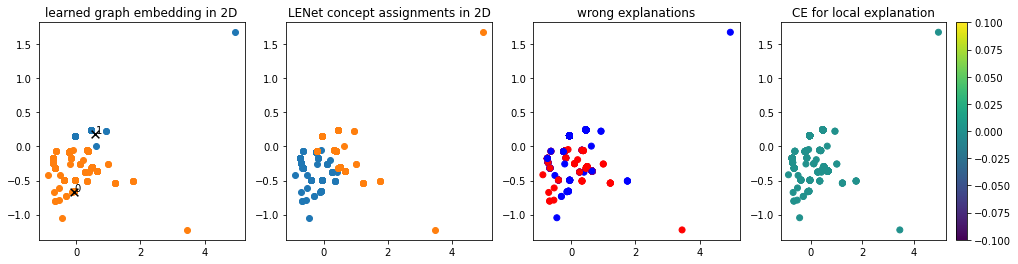

Concept Purity: 0.878362 +- 0.121638
Concept distribution:  (array([0, 1], dtype=int64), array([201, 818], dtype=int64))
Alpha norms:
tensor([[1.0000, 0.7147],
        [0.8292, 1.0000]])
Logic formulas:
For class 0:
0.7673130193905817 ((feature001) | ((feature001 & feature000)
For class 1:
0.0 ()
Accuracy as classifier:  0.0

 10: Loss: 0.06938, LEN: 0.063779, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.64, V. Acc: 0.77, V. Loss: 0.08965, V. LEN 0.08
 11: Loss: 0.06843, LEN: 0.063513, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.62, V. Acc: 0.77, V. Loss: 0.09037, V. LEN 0.08
 12: Loss: 0.06730, LEN: 0.063314, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.57, V. Acc: 0.77, V. Loss: 0.09322, V. LEN 0.08
 13: Loss: 0.06710, LEN: 0.063051, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.48, V. Acc: 0.77, V. Loss: 0.09558, V. LEN 0.08
 14: Loss: 0.06686, LEN: 0.062763, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.44, V. Acc: 0.77, V. Loss: 0.09574, V. LEN 0.08
 15: Loss: 0.06621, LEN: 0.062695, Debug: 0.000

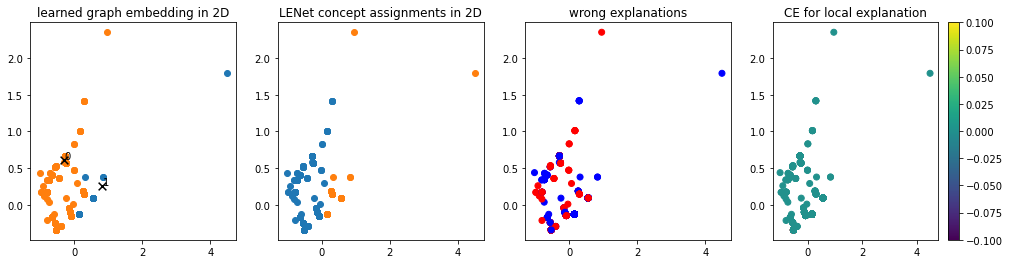

Concept Purity: 0.988170 +- 0.011830
Concept distribution:  (array([0, 1], dtype=int64), array([385, 634], dtype=int64))
Alpha norms:
tensor([[0.9853, 1.0000],
        [0.8210, 1.0000]])
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0

 20: Loss: 0.06390, LEN: 0.061205, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.08712, V. LEN 0.08
 21: Loss: 0.06302, LEN: 0.060975, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.08585, V. LEN 0.08
 22: Loss: 0.06270, LEN: 0.060668, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.08421, V. LEN 0.08
 23: Loss: 0.06225, LEN: 0.060477, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.08236, V. LEN 0.08
 24: Loss: 0.06161, LEN: 0.059905, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.08151, V. LEN 0.08
 25: Loss: 0.06117, LEN: 0.059608, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss

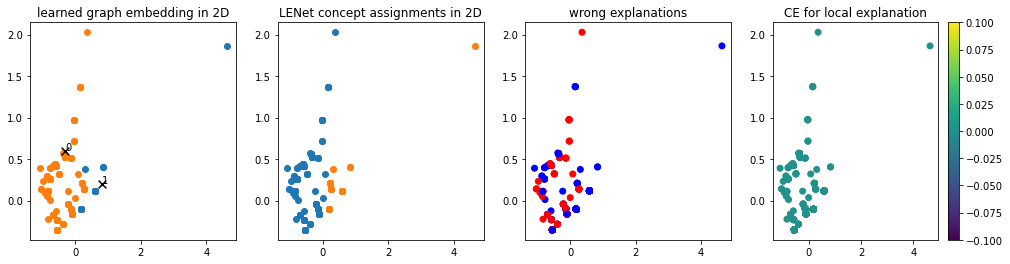

Concept Purity: 0.988942 +- 0.011058
Concept distribution:  (array([0, 1], dtype=int64), array([386, 633], dtype=int64))
Alpha norms:
tensor([[0.7297, 1.0000],
        [0.7331, 1.0000]])
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0

 30: Loss: 0.05960, LEN: 0.058167, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.07931, V. LEN 0.08
 31: Loss: 0.05951, LEN: 0.057689, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.07774, V. LEN 0.07
 32: Loss: 0.05858, LEN: 0.057160, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.07707, V. LEN 0.07
 33: Loss: 0.05870, LEN: 0.056869, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.07695, V. LEN 0.07
 34: Loss: 0.05799, LEN: 0.056627, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.07629, V. LEN 0.07
 35: Loss: 0.05761, LEN: 0.056287, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss

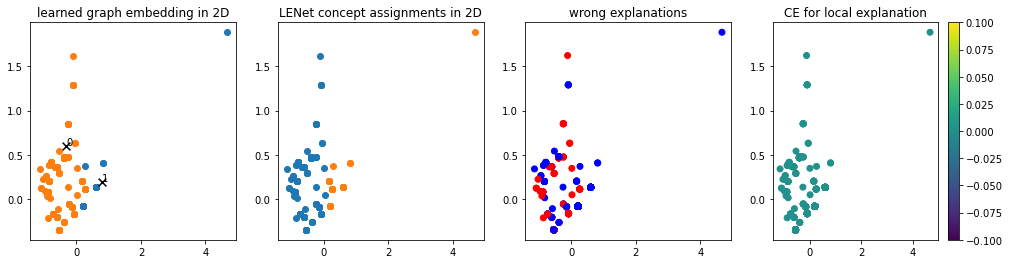

Concept Purity: 0.988942 +- 0.011058
Concept distribution:  (array([0, 1], dtype=int64), array([386, 633], dtype=int64))
Alpha norms:
tensor([[0.5600, 1.0000],
        [0.6423, 1.0000]])
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0

 40: Loss: 0.05543, LEN: 0.054231, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.07366, V. LEN 0.07
 41: Loss: 0.05525, LEN: 0.053960, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.07253, V. LEN 0.07
 42: Loss: 0.05470, LEN: 0.053542, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.07297, V. LEN 0.07
 43: Loss: 0.05454, LEN: 0.053303, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.07211, V. LEN 0.07
 44: Loss: 0.05429, LEN: 0.053142, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss: 0.07104, V. LEN 0.07
 45: Loss: 0.05320, LEN: 0.052164, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.74, V. Acc: 0.77, V. Loss

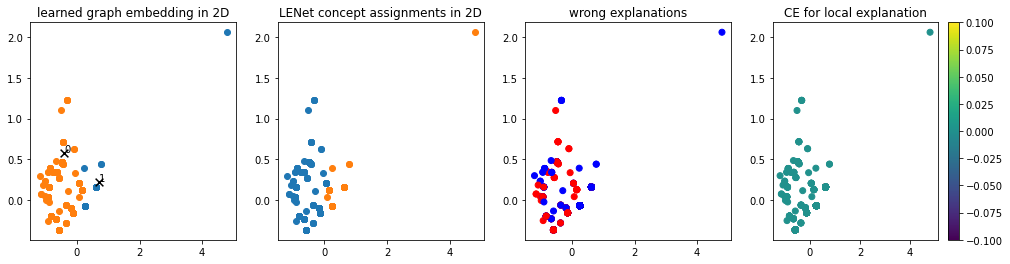

Concept Purity: 0.992834 +- 0.007166
Concept distribution:  (array([0, 1], dtype=int64), array([391, 628], dtype=int64))
Alpha norms:
tensor([[0.4698, 1.0000],
        [0.6153, 1.0000]])
Logic formulas:
For class 0:
0.8199445983379502 (feature001) | ((feature000 & feature001)
For class 1:
0.0 ()
Accuracy as classifier:  0.0

 50: Loss: 0.05176, LEN: 0.050582, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.61, V. Acc: 0.77, V. Loss: 0.06659, V. LEN 0.06
 51: Loss: 0.05117, LEN: 0.049742, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.61, V. Acc: 0.77, V. Loss: 0.06704, V. LEN 0.06
 52: Loss: 0.05081, LEN: 0.049738, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.61, V. Acc: 0.77, V. Loss: 0.06650, V. LEN 0.06
 53: Loss: 0.04981, LEN: 0.048592, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.62, V. Acc: 0.77, V. Loss: 0.06572, V. LEN 0.06
 54: Loss: 0.05028, LEN: 0.049130, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.60, V. Acc: 0.77, V. Loss: 0.06445, V. LEN 0.06
 55: Loss: 0.04943, LEN: 0.048127, Debug: 0.0000

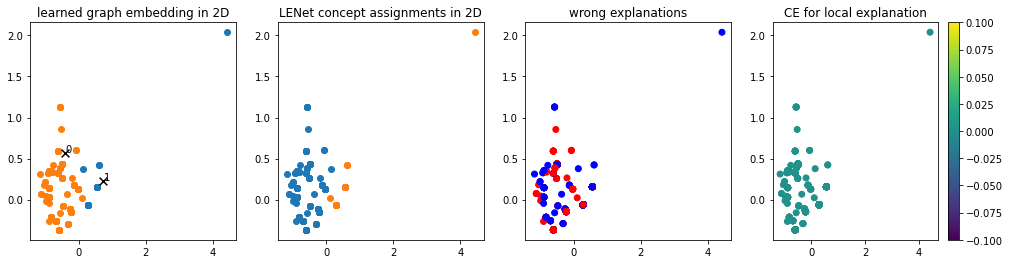

Concept Purity: 0.997942 +- 0.000442
Concept distribution:  (array([0, 1], dtype=int64), array([400, 619], dtype=int64))
Alpha norms:
tensor([[0.4115, 1.0000],
        [0.6424, 1.0000]])
Logic formulas:
For class 0:
0.8282548476454293 (feature001) | ((feature000 & feature001)
For class 1:
0.0 ()
Accuracy as classifier:  0.0

 60: Loss: 0.04758, LEN: 0.046863, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.59, V. Acc: 0.77, V. Loss: 0.05971, V. LEN 0.06
 61: Loss: 0.04631, LEN: 0.045472, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.60, V. Acc: 0.77, V. Loss: 0.05906, V. LEN 0.06
 62: Loss: 0.04704, LEN: 0.045894, Debug: 0.0000, Tr. Acc: 0.74, Tr. AccO: 0.59, V. Acc: 0.77, V. Loss: 0.05797, V. LEN 0.06
 63: Loss: 0.04694, LEN: 0.045725, Debug: 0.0000, Tr. Acc: 0.75, Tr. AccO: 0.61, V. Acc: 0.86, V. Loss: 0.05834, V. LEN 0.05
 64: Loss: 0.04573, LEN: 0.044555, Debug: 0.0000, Tr. Acc: 0.82, Tr. AccO: 0.61, V. Acc: 0.86, V. Loss: 0.05739, V. LEN 0.05
 65: Loss: 0.04498, LEN: 0.044168, Debug: 0.0000

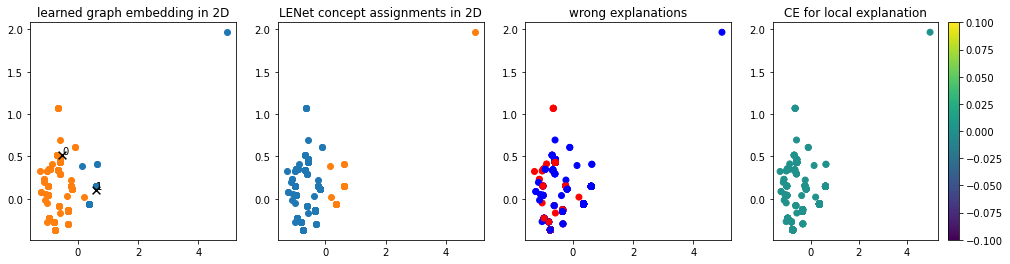

Concept Purity: 0.999194 +- 0.000806
Concept distribution:  (array([0, 1], dtype=int64), array([399, 620], dtype=int64))
Alpha norms:
tensor([[0.3753, 1.0000],
        [0.6352, 1.0000]])
Logic formulas:
For class 0:
0.8296398891966759 (feature001) | ((feature000 & feature001)
For class 1:
0.0 ()
Accuracy as classifier:  0.0

 70: Loss: 0.04415, LEN: 0.043156, Debug: 0.0000, Tr. Acc: 0.82, Tr. AccO: 0.61, V. Acc: 0.86, V. Loss: 0.05251, V. LEN 0.05
 71: Loss: 0.04299, LEN: 0.042086, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.62, V. Acc: 0.86, V. Loss: 0.05245, V. LEN 0.05
 72: Loss: 0.04286, LEN: 0.042041, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.62, V. Acc: 0.86, V. Loss: 0.05231, V. LEN 0.05
 73: Loss: 0.04314, LEN: 0.042286, Debug: 0.0000, Tr. Acc: 0.82, Tr. AccO: 0.61, V. Acc: 0.86, V. Loss: 0.05169, V. LEN 0.05
 74: Loss: 0.04266, LEN: 0.041767, Debug: 0.0000, Tr. Acc: 0.82, Tr. AccO: 0.62, V. Acc: 0.86, V. Loss: 0.05111, V. LEN 0.05
 75: Loss: 0.04218, LEN: 0.041517, Debug: 0.0000

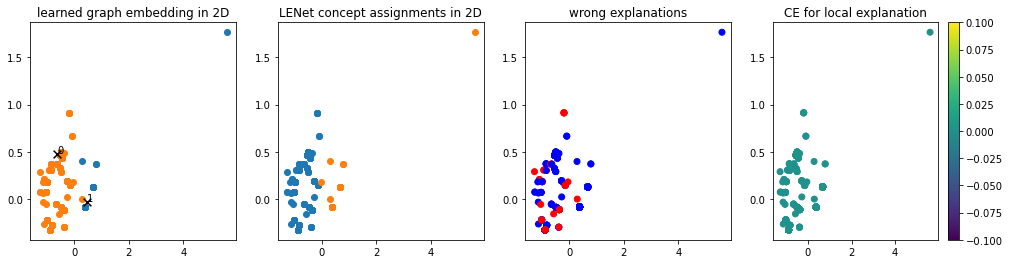

Concept Purity: 0.998390 +- 0.001610
Concept distribution:  (array([0, 1], dtype=int64), array([398, 621], dtype=int64))
Alpha norms:
tensor([[0.3612, 1.0000],
        [0.5806, 1.0000]])
Logic formulas:
For class 0:
0.8282548476454293 (feature001) | ((feature000 & feature001)
For class 1:
0.8282548476454293 ((feature000)
Accuracy as classifier:  0.8283

 80: Loss: 0.04104, LEN: 0.040180, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04923, V. LEN 0.05
 81: Loss: 0.04030, LEN: 0.039613, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04909, V. LEN 0.05
 82: Loss: 0.04039, LEN: 0.039396, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04883, V. LEN 0.05
 83: Loss: 0.04056, LEN: 0.039940, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04812, V. LEN 0.05
 84: Loss: 0.04000, LEN: 0.039350, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04811, V. LEN 0.05
 85: Loss: 0.04013,

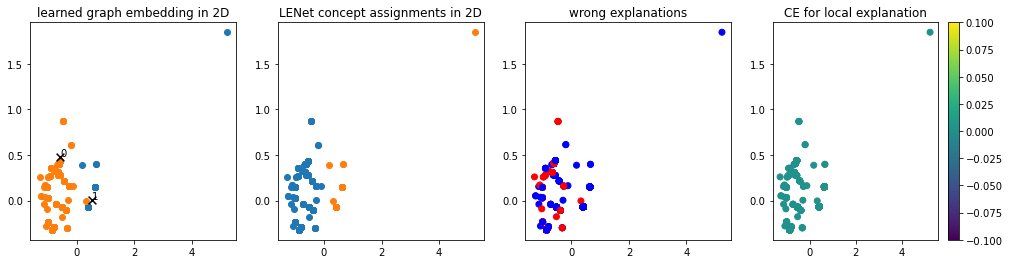

Concept Purity: 0.999194 +- 0.000806
Concept distribution:  (array([0, 1], dtype=int64), array([399, 620], dtype=int64))
Alpha norms:
tensor([[0.3539, 1.0000],
        [0.5569, 1.0000]])
Logic formulas:
For class 0:
0.8296398891966759 (feature001) | ((feature000 & feature001)
For class 1:
0.8296398891966759 ((feature000)
Accuracy as classifier:  0.8296

 90: Loss: 0.03943, LEN: 0.038541, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04679, V. LEN 0.05
 91: Loss: 0.03926, LEN: 0.038707, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04710, V. LEN 0.04
 92: Loss: 0.03988, LEN: 0.038906, Debug: 0.0000, Tr. Acc: 0.82, Tr. AccO: 0.82, V. Acc: 0.86, V. Loss: 0.04869, V. LEN 0.04
 93: Loss: 0.03960, LEN: 0.038666, Debug: 0.0000, Tr. Acc: 0.82, Tr. AccO: 0.82, V. Acc: 0.86, V. Loss: 0.04877, V. LEN 0.04
 94: Loss: 0.04053, LEN: 0.039627, Debug: 0.0000, Tr. Acc: 0.82, Tr. AccO: 0.82, V. Acc: 0.86, V. Loss: 0.04619, V. LEN 0.04
 95: Loss: 0.03924,

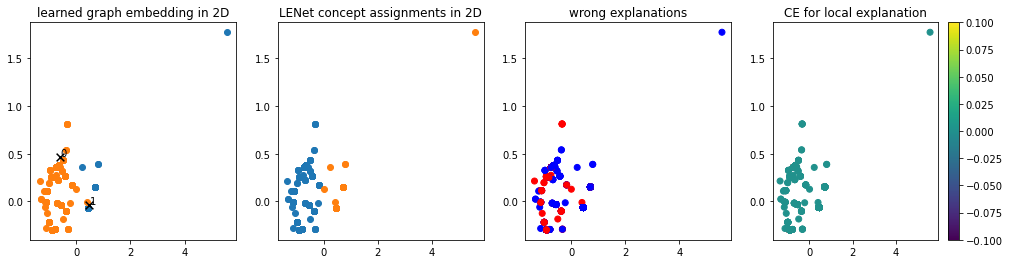

Concept Purity: 0.998390 +- 0.001610
Concept distribution:  (array([0, 1], dtype=int64), array([398, 621], dtype=int64))
Alpha norms:
tensor([[0.3617, 1.0000],
        [0.5753, 1.0000]])
Logic formulas:
For class 0:
0.8282548476454293 (feature001) | ((feature000 & feature001)
For class 1:
0.8282548476454293 ((feature000)
Accuracy as classifier:  0.8283

100: Loss: 0.03864, LEN: 0.038178, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04497, V. LEN 0.04
101: Loss: 0.03916, LEN: 0.038533, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04508, V. LEN 0.04
102: Loss: 0.03783, LEN: 0.037416, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04314, V. LEN 0.04
103: Loss: 0.03935, LEN: 0.038782, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04490, V. LEN 0.04
104: Loss: 0.03864, LEN: 0.038195, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04450, V. LEN 0.04
105: Loss: 0.03827,

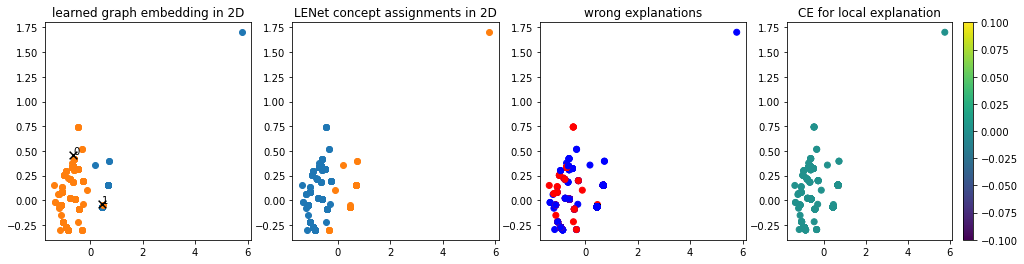

Concept Purity: 0.995200 +- 0.004800
Concept distribution:  (array([0, 1], dtype=int64), array([394, 625], dtype=int64))
Alpha norms:
tensor([[0.3806, 1.0000],
        [0.6284, 1.0000]])
Logic formulas:
For class 0:
0.8282548476454293 (feature001) | ((feature000 & feature001)
For class 1:
0.8282548476454293 ((feature000)
Accuracy as classifier:  0.8283

110: Loss: 0.03867, LEN: 0.038170, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04171, V. LEN 0.04
111: Loss: 0.03838, LEN: 0.037840, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04378, V. LEN 0.04
112: Loss: 0.03893, LEN: 0.038346, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04467, V. LEN 0.04
113: Loss: 0.03860, LEN: 0.037958, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04475, V. LEN 0.04
114: Loss: 0.03885, LEN: 0.038180, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04411, V. LEN 0.04
115: Loss: 0.03795,

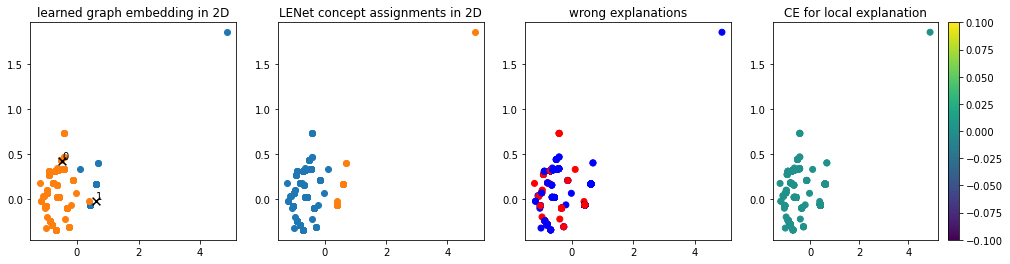

Concept Purity: 0.997942 +- 0.000442
Concept distribution:  (array([0, 1], dtype=int64), array([400, 619], dtype=int64))
Alpha norms:
tensor([[0.4006, 1.0000],
        [0.6861, 1.0000]])
Logic formulas:
For class 0:
0.8282548476454293 (feature001) | ((feature000 & feature001)
For class 1:
0.8282548476454293 ((feature000)
Accuracy as classifier:  0.8283

120: Loss: 0.03788, LEN: 0.037394, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04531, V. LEN 0.04
121: Loss: 0.03938, LEN: 0.038877, Debug: 0.0000, Tr. Acc: 0.82, Tr. AccO: 0.82, V. Acc: 0.86, V. Loss: 0.04526, V. LEN 0.04
122: Loss: 0.03894, LEN: 0.038389, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04493, V. LEN 0.04
123: Loss: 0.03830, LEN: 0.037992, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04534, V. LEN 0.04
124: Loss: 0.03775, LEN: 0.037352, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04505, V. LEN 0.04
125: Loss: 0.03863,

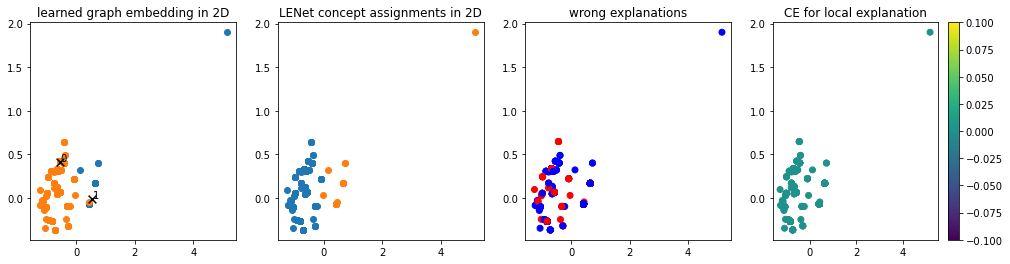

Concept Purity: 0.998390 +- 0.001610
Concept distribution:  (array([0, 1], dtype=int64), array([398, 621], dtype=int64))
Alpha norms:
tensor([[0.4216, 1.0000],
        [0.7235, 1.0000]])
Logic formulas:
For class 0:
0.8282548476454293 (feature001) | ((feature000 & feature001)
For class 1:
0.8282548476454293 ((feature000)
Accuracy as classifier:  0.8283

130: Loss: 0.03775, LEN: 0.037302, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04440, V. LEN 0.04
131: Loss: 0.03810, LEN: 0.037553, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04431, V. LEN 0.04
132: Loss: 0.03796, LEN: 0.037405, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04417, V. LEN 0.04
133: Loss: 0.03771, LEN: 0.037233, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04602, V. LEN 0.04
134: Loss: 0.03924, LEN: 0.038787, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04685, V. LEN 0.04
135: Loss: 0.03795,

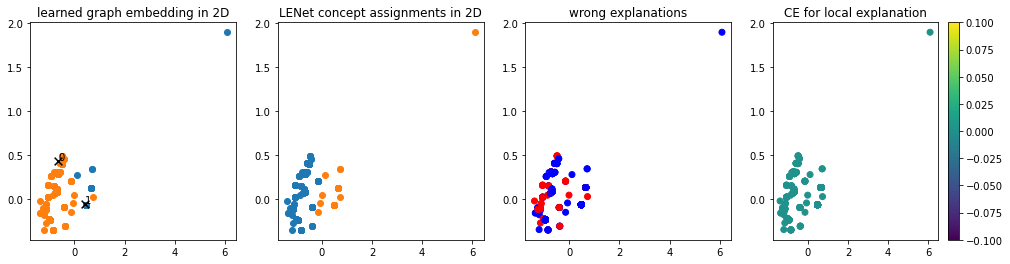

Concept Purity: 0.996790 +- 0.003210
Concept distribution:  (array([0, 1], dtype=int64), array([396, 623], dtype=int64))
Alpha norms:
tensor([[0.4428, 1.0000],
        [0.7586, 1.0000]])
Logic formulas:
For class 0:
0.8296398891966759 (feature001) | ((feature000 & feature001)
For class 1:
0.8296398891966759 ((feature000)
Accuracy as classifier:  0.8296

140: Loss: 0.03811, LEN: 0.037461, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04448, V. LEN 0.04
141: Loss: 0.03869, LEN: 0.038203, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04449, V. LEN 0.04
142: Loss: 0.03803, LEN: 0.037625, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04475, V. LEN 0.04
143: Loss: 0.03743, LEN: 0.037076, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04490, V. LEN 0.04
144: Loss: 0.03774, LEN: 0.037294, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04464, V. LEN 0.04
145: Loss: 0.03774,

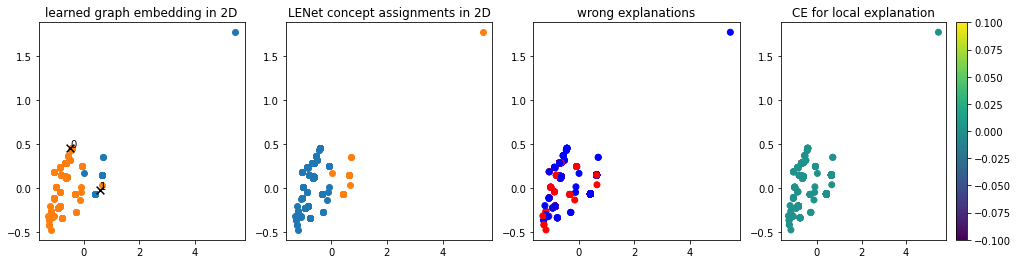

Concept Purity: 0.999194 +- 0.000806
Concept distribution:  (array([0, 1], dtype=int64), array([399, 620], dtype=int64))
Alpha norms:
tensor([[0.4612, 1.0000],
        [0.7891, 1.0000]])
Logic formulas:
For class 0:
0.8296398891966759 (feature001) | ((feature000 & feature001)
For class 1:
0.8296398891966759 ((feature000)
Accuracy as classifier:  0.8296

150: Loss: 0.03848, LEN: 0.038116, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04485, V. LEN 0.04
151: Loss: 0.03795, LEN: 0.037495, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04495, V. LEN 0.04
152: Loss: 0.03837, LEN: 0.037879, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04575, V. LEN 0.04
153: Loss: 0.03795, LEN: 0.037540, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04564, V. LEN 0.04
154: Loss: 0.03820, LEN: 0.037730, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04653, V. LEN 0.04
155: Loss: 0.03788,

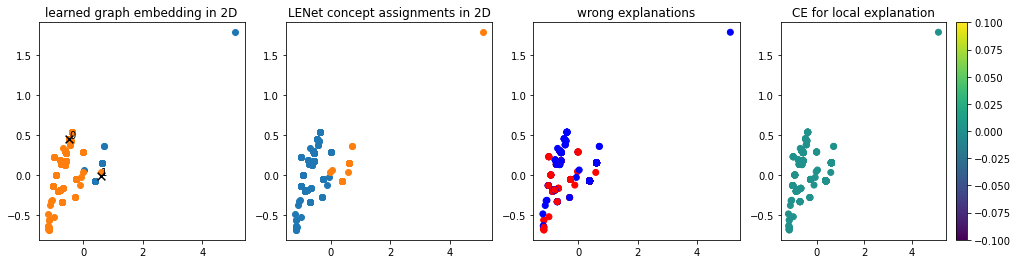

Concept Purity: 0.998390 +- 0.001610
Concept distribution:  (array([0, 1], dtype=int64), array([398, 621], dtype=int64))
Alpha norms:
tensor([[0.4812, 1.0000],
        [0.8133, 1.0000]])
Logic formulas:
For class 0:
0.8282548476454293 (feature001) | ((feature000 & feature001)
For class 1:
0.8282548476454293 ((feature000)
Accuracy as classifier:  0.8283

160: Loss: 0.03713, LEN: 0.036791, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04516, V. LEN 0.04
161: Loss: 0.03783, LEN: 0.037496, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04493, V. LEN 0.04
162: Loss: 0.03725, LEN: 0.036955, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04480, V. LEN 0.04
163: Loss: 0.03819, LEN: 0.037955, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04503, V. LEN 0.04
164: Loss: 0.03823, LEN: 0.037931, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04660, V. LEN 0.04
165: Loss: 0.03740,

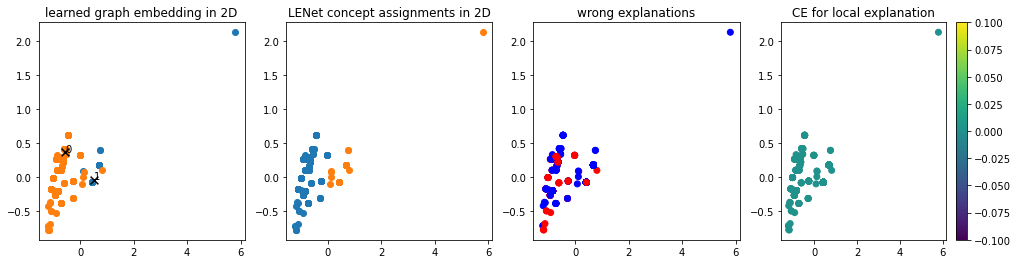

Concept Purity: 0.996790 +- 0.003210
Concept distribution:  (array([0, 1], dtype=int64), array([396, 623], dtype=int64))
Alpha norms:
tensor([[0.5016, 1.0000],
        [0.8396, 1.0000]])
Logic formulas:
For class 0:
0.8296398891966759 (feature001) | ((feature000 & feature001)
For class 1:
0.8296398891966759 ((feature000)
Accuracy as classifier:  0.8296

170: Loss: 0.03852, LEN: 0.038176, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04428, V. LEN 0.04
171: Loss: 0.03897, LEN: 0.038610, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04490, V. LEN 0.04
172: Loss: 0.03773, LEN: 0.037357, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04446, V. LEN 0.04
173: Loss: 0.03828, LEN: 0.037919, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04482, V. LEN 0.04
174: Loss: 0.03772, LEN: 0.037366, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04524, V. LEN 0.04
175: Loss: 0.03769,

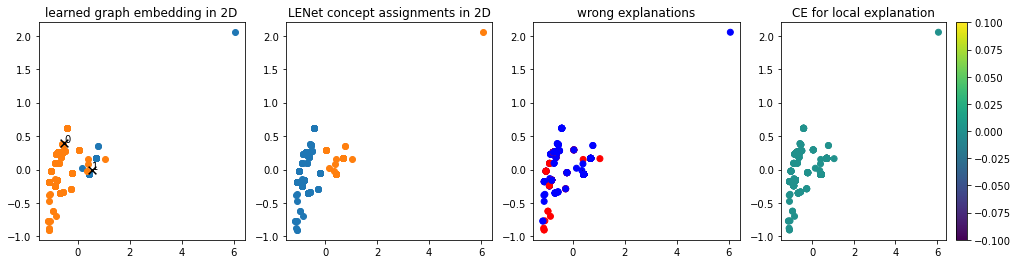

Concept Purity: 0.992051 +- 0.007949
Concept distribution:  (array([0, 1], dtype=int64), array([390, 629], dtype=int64))
Alpha norms:
tensor([[0.5159, 1.0000],
        [0.8598, 1.0000]])
Logic formulas:
For class 0:
0.8337950138504155 (feature001) | ((feature000 & feature001)
For class 1:
0.8337950138504155 ((feature000)
Accuracy as classifier:  0.8338

180: Loss: 0.03769, LEN: 0.037361, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04651, V. LEN 0.05
181: Loss: 0.03763, LEN: 0.037220, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04384, V. LEN 0.04
182: Loss: 0.03734, LEN: 0.037000, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04568, V. LEN 0.05
183: Loss: 0.03825, LEN: 0.037935, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04616, V. LEN 0.05
184: Loss: 0.03727, LEN: 0.036875, Debug: 0.0000, Tr. Acc: 0.84, Tr. AccO: 0.84, V. Acc: 0.86, V. Loss: 0.04622, V. LEN 0.05
185: Loss: 0.03771,

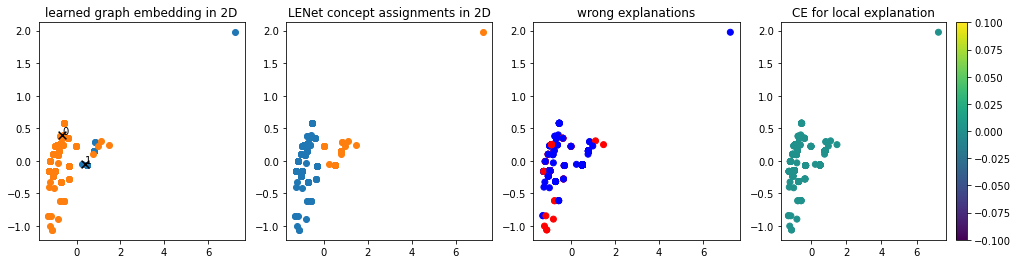

Concept Purity: 0.992051 +- 0.007949
Concept distribution:  (array([0, 1], dtype=int64), array([390, 629], dtype=int64))
Alpha norms:
tensor([[0.5344, 1.0000],
        [0.8897, 1.0000]])
Logic formulas:
For class 0:
0.8337950138504155 (feature001) | ((feature000 & feature001)
For class 1:
0.8337950138504155 ((feature000)
Accuracy as classifier:  0.8338

190: Loss: 0.03784, LEN: 0.037435, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04631, V. LEN 0.05
191: Loss: 0.03778, LEN: 0.037288, Debug: 0.0000, Tr. Acc: 0.84, Tr. AccO: 0.84, V. Acc: 0.86, V. Loss: 0.04626, V. LEN 0.05
192: Loss: 0.03847, LEN: 0.037848, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04561, V. LEN 0.05
193: Loss: 0.03773, LEN: 0.037286, Debug: 0.0000, Tr. Acc: 0.84, Tr. AccO: 0.84, V. Acc: 0.86, V. Loss: 0.04585, V. LEN 0.05
194: Loss: 0.03853, LEN: 0.038145, Debug: 0.0000, Tr. Acc: 0.83, Tr. AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04742, V. LEN 0.05
195: Loss: 0.03702,

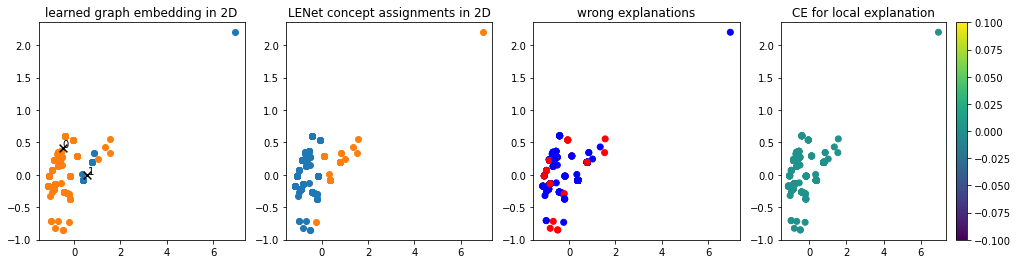

Concept Purity: 0.991270 +- 0.008730
Concept distribution:  (array([0, 1], dtype=int64), array([389, 630], dtype=int64))
Alpha norms:
tensor([[0.5533, 1.0000],
        [0.9109, 1.0000]])
Logic formulas:
For class 0:
0.8351800554016621 (feature001) | ((feature000 & feature001)
For class 1:
0.8351800554016621 ((feature000)
Accuracy as classifier:  0.8352

200: Loss: 0.03690, LEN: 0.036575, Debug: 0.0000, Tr. Acc: 0.84, Tr. AccO: 0.84, V. Acc: 0.86, V. Loss: 0.04806, V. LEN 0.05
201: Loss: 0.03734, LEN: 0.037004, Debug: 0.0000, Tr. Acc: 0.84, Tr. AccO: 0.84, V. Acc: 0.86, V. Loss: 0.04820, V. LEN 0.05
202: Loss: 0.03806, LEN: 0.037652, Debug: 0.0000, Tr. Acc: 0.84, Tr. AccO: 0.84, V. Acc: 0.86, V. Loss: 0.04858, V. LEN 0.05
203: Loss: 0.03682, LEN: 0.036512, Debug: 0.0000, Tr. Acc: 0.84, Tr. AccO: 0.84, V. Acc: 0.86, V. Loss: 0.04861, V. LEN 0.05
204: Loss: 0.03749, LEN: 0.037237, Debug: 0.0000, Tr. Acc: 0.84, Tr. AccO: 0.84, V. Acc: 0.86, V. Loss: 0.04760, V. LEN 0.05
205: Loss: 0.03663,

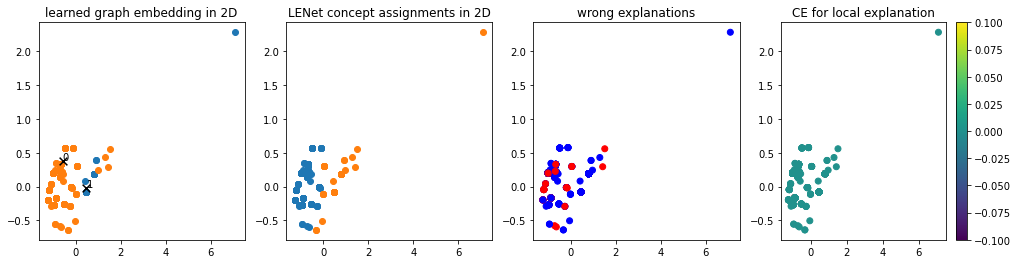

Concept Purity: 0.986635 +- 0.013365
Concept distribution:  (array([0, 1], dtype=int64), array([383, 636], dtype=int64))
Alpha norms:
tensor([[0.5644, 1.0000],
        [0.9237, 1.0000]])
Logic formulas:
For class 0:
0.8365650969529086 (feature001) | ((feature000 & feature001)
For class 1:
0.8365650969529086 ((feature000)
Accuracy as classifier:  0.8366

210: Loss: 0.03737, LEN: 0.036949, Debug: 0.0000, Tr. Acc: 0.84, Tr. AccO: 0.84, V. Acc: 0.86, V. Loss: 0.04619, V. LEN 0.05
211: Loss: 0.03673, LEN: 0.036385, Debug: 0.0000, Tr. Acc: 0.84, Tr. AccO: 0.84, V. Acc: 0.86, V. Loss: 0.04751, V. LEN 0.05
Early Stopping
Best epoch: 110


In [15]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(train_dataset, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(val_dataset, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(test_dataset, batch_sampler=batch_sampler)

torch.manual_seed(42)
hyper = {
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 2,
    "dim_prototypes": 10,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "log_images": False,
    "log_models": False
}

len_model = models.LEN(hyper["num_prototypes"], hyper["LEN_temperature"], True).to(device)
le_model2 = models.LEEmbedder(num_features=14, activation=hyper["activation"], num_hidden=hyper["dim_prototypes"]).to(device)
proto_model2 = ProtoModel(len_model, 
                         le_model2, 
                         train_group_loader, 
                         val_group_loader, 
                         device, 
                         hyper_params=hyper).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
proto_model2.iterate(num_epochs=400, log_wandb=False, name_wandb=f"MUTAG LEN 2prots {prefix} {hyper['activation']}+{hyper['assign_func']}")

In [16]:
9/101 , 9/100

(0.0891089108910891, 0.09)

In [106]:
#proto_model2.inspect_embedding(test_group_loader)

x_train , emb , concepts_assignement , y_train_1h , new_le_classes , le_idxs , new_belong = proto_model2.get_concept_vector(group_loader, return_raw=True)
preds = len_model(x_train).squeeze(-1)

In [35]:
##
# Why 0.84 of accuracy?
# How many samples of class 1 have a NO2?
##
x_train , emb , concepts_assignement , y_train_1h , new_le_classes , le_idxs , new_belong = proto_model2.get_concept_vector(group_loader, return_raw=True)
preds = len_model(x_train).squeeze(-1)


belonging = np.array(belonging)
le_classes = np.array(le_classes)

c = 0
for b in np.unique(belonging):
    if ori_classes[b] == 1 and 0 in le_classes[belonging == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes))

c = 0
for b in np.unique(belonging):
    if ori_classes[b] == 0 and 0 not in le_classes[belonging == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes))

missclass = concepts_assignement.argmax(-1)[new_le_classes == 1].sum()
print("Local expl of class 1 being assigned to the concept of NO2: ", (missclass / len(dataset)).item())
missclass = (concepts_assignement.argmax(-1)[new_le_classes == 0] == 0).sum()
print("Local expl of class 0 being assigned to the wrong concept: ", (missclass / len(dataset)).item())

Samples of class 1 containing NO2:  0.04111111111111111
Samples of class 0 not containing NO2:  0.12333333333333334
Local expl of class 1 being assigned to the concept of NO2:  0.012539184652268887
Local expl of class 0 being assigned to the wrong concept:  0.0


In [34]:
(preds.argmax(-1) == y_train_1h.argmax(-1)).sum() / len(ori_classes)

tensor(0.8411)

In [10]:
print(np.unique(le_classes, return_counts=True))
print(torch.unique(dataset.data.task_y, return_counts=True))

(array([0, 1]), array([772, 504], dtype=int64))
(tensor([0, 1]), tensor([945, 331]))


In [94]:
le_classes = np.array(le_classes)

In [63]:
np.unique(np.array(le_classes_train)[train_dataset.data.task_y == 0], return_counts=True)

(array([0, 1]), array([580, 168], dtype=int64))

In [64]:
np.unique(np.array(le_classes_train)[train_dataset.data.task_y == 1], return_counts=True)

(array([0, 1]), array([ 39, 232], dtype=int64))

In [14]:
43 / len(dataset)

0.03369905956112853

In [25]:
preds[torch.logical_and(preds[:, 0] < 0, preds[:, 1] < 0)]

tensor([], size=(0, 2), grad_fn=<IndexBackward0>)

## Testing different num_prototypes

In [ ]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging))
group_loader = DataLoader(dataset, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 8,
    "dim_prototypes": 10,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "log_images": True
}

len_model = models.LEN(hyper["num_prototypes"], hyper["LEN_temperature"]).to(device)
le_model2 = models.LEEmbedderMNIST(num_features=5, activation=hyper["activation"], num_hidden=hyper["dim_prototypes"]).to(device)
proto_model2 = ProtoModel(len_model, 
                         le_model2, 
                         torch.tensor(belonging, dtype=torch.int64, device=device), 
                         group_loader, 
                         y_train_1h.to(device),
                         device, 
                         hyper_params=hyper).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
proto_model2.iterate(num_epochs=2000, log_wandb=True, name_wandb=f"LEN 8prots {prefix} Hard {hyper['activation']}+{hyper['assign_func']} mb")

In [ ]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging))
group_loader = DataLoader(dataset, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 10,
    "dim_prototypes": 10,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "log_images": True
}

len_model = models.LEN(hyper["num_prototypes"], hyper["LEN_temperature"]).to(device)
le_model2 = models.LEEmbedderMNIST(num_features=5, activation=hyper["activation"], num_hidden=hyper["dim_prototypes"]).to(device)
proto_model2 = ProtoModel(len_model, 
                         le_model2, 
                         torch.tensor(belonging, dtype=torch.int64, device=device), 
                         group_loader, 
                         y_train_1h.to(device),
                         device, 
                         hyper_params=hyper).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
proto_model2.iterate(num_epochs=2000, log_wandb=True, name_wandb=f"LEN 10prots {prefix} Hard {hyper['activation']}+{hyper['assign_func']} mb")

In [ ]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging))
group_loader = DataLoader(dataset, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 12,
    "dim_prototypes": 10,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "log_images": True
}

len_model = models.LEN(hyper["num_prototypes"], hyper["LEN_temperature"]).to(device)
le_model2 = models.LEEmbedderMNIST(num_features=5, activation=hyper["activation"], num_hidden=hyper["dim_prototypes"]).to(device)
proto_model2 = ProtoModel(len_model, 
                         le_model2, 
                         torch.tensor(belonging, dtype=torch.int64, device=device), 
                         group_loader, 
                         y_train_1h.to(device),
                         device, 
                         hyper_params=hyper).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
proto_model2.iterate(num_epochs=2000, log_wandb=True, name_wandb=f"LEN 12prots {prefix} Hard {hyper['activation']}+{hyper['assign_func']} mb")

In [ ]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging))
group_loader = DataLoader(dataset, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 7,
    "dim_prototypes": 10,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "log_images": True
}

len_model = models.LEN(hyper["num_prototypes"], hyper["LEN_temperature"]).to(device)
le_model2 = models.LEEmbedderMNIST(num_features=5, activation=hyper["activation"], num_hidden=hyper["dim_prototypes"]).to(device)
proto_model2 = ProtoModel(len_model, 
                         le_model2, 
                         torch.tensor(belonging, dtype=torch.int64, device=device), 
                         group_loader, 
                         y_train_1h.to(device),
                         device, 
                         hyper_params=hyper).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
proto_model2.iterate(num_epochs=2000, log_wandb=True, name_wandb=f"LEN 7prots {prefix} Hard {hyper['activation']}+{hyper['assign_func']} mb")

In [ ]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging))
group_loader = DataLoader(dataset, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 6,
    "dim_prototypes": 10,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "log_images": True
}

len_model = models.LEN(hyper["num_prototypes"], hyper["LEN_temperature"]).to(device)
le_model2 = models.LEEmbedderMNIST(num_features=5, activation=hyper["activation"], num_hidden=hyper["dim_prototypes"]).to(device)
proto_model2 = ProtoModel(len_model, 
                         le_model2, 
                         torch.tensor(belonging, dtype=torch.int64, device=device), 
                         group_loader, 
                         y_train_1h.to(device),
                         device, 
                         hyper_params=hyper).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
proto_model2.iterate(num_epochs=2000, log_wandb=True, name_wandb=f"LEN 6prots {prefix} Hard {hyper['activation']}+{hyper['assign_func']} mb")

In [ ]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging))
group_loader = DataLoader(dataset, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 5,
    "dim_prototypes": 10,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "log_images": True
}

len_model = models.LEN(hyper["num_prototypes"], hyper["LEN_temperature"]).to(device)
le_model2 = models.LEEmbedderMNIST(num_features=5, activation=hyper["activation"], num_hidden=hyper["dim_prototypes"]).to(device)
proto_model2 = ProtoModel(len_model, 
                         le_model2, 
                         torch.tensor(belonging, dtype=torch.int64, device=device), 
                         group_loader, 
                         y_train_1h.to(device),
                         device, 
                         hyper_params=hyper).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
proto_model2.iterate(num_epochs=2000, log_wandb=True, name_wandb=f"LEN 5prots {prefix} Hard {hyper['activation']}+{hyper['assign_func']} mb")

In [ ]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging))
group_loader = DataLoader(dataset, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 4,
    "dim_prototypes": 10,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "log_images": True
}

len_model = models.LEN(hyper["num_prototypes"], hyper["LEN_temperature"]).to(device)
le_model2 = models.LEEmbedderMNIST(num_features=5, activation=hyper["activation"], num_hidden=hyper["dim_prototypes"]).to(device)
proto_model2 = ProtoModel(len_model, 
                         le_model2, 
                         torch.tensor(belonging, dtype=torch.int64, device=device), 
                         group_loader, 
                         y_train_1h.to(device),
                         device, 
                         hyper_params=hyper).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
proto_model2.iterate(num_epochs=2000, log_wandb=True, name_wandb=f"LEN 4prots {prefix} Hard {hyper['activation']}+{hyper['assign_func']} mb")

In [17]:
from networkx.algorithms import isomorphism as iso

pattern_no2 = nx.Graph()
pattern_no2.add_nodes_from([
    (0, {"atom_type": 1}),
    (1, {"atom_type": 4}),
    (2, {"atom_type": 1})
])
pattern_no2.add_edges_from([(0,1), (1,2)])

pattern_nh2 = nx.Graph()
pattern_nh2.add_nodes_from([
    (0, {"atom_type": 3}),
    (1, {"atom_type": 4}),
    (2, {"atom_type": 3})
])
pattern_nh2.add_edges_from([(0,1), (1,2)])

In [36]:
def read_mutagenicity(explainer="PGExplainer", model="GCN_TF", split="TRAIN", evaluate_method=True, min_num_include=None, manual_cut=None, small=None):
    base_path = base + f"{explainer}/Mutagenicity/{model}/"
    base_path_emb = base_emb + f"Mutagenicity/{model}/"
    adjs , edge_weights , index_stopped = [] , [] , []
    ori_adjs, ori_edge_weights, ori_classes , belonging , ori_predictions = [], [], [] , [] , []
    precomputed_embeddings, ori_embeddings = [], []
    le_classes = []
    ori_idxs , nodes_kept = [] , []
    counter_classes_added = defaultdict(int)
    q = 0

    num_multi_shapes_removed , num_class_relationship_broken , cont_num_iter , num_iter = 0 , 0 , 0 , 0
    for split in [split]:
        path = base_path + split + "/"
        path_emb = base_path_emb + split + "/"
        for c in ["0", "1"]:
            for _ , pp in enumerate(os.listdir(path + c + "/")):
                graph_id = int(pp.split("_")[1].split(".")[0])
                gnn_pred = int(pp.split("_")[0])
                if gnn_pred != int(c):
                    continue
                adj = np.load(path + c + "/" + pp, allow_pickle=True)
                features = np.load(path + "features" + "/" + pp, allow_pickle=True)
                embedding = None
                                
                if manual_cut is None:
                    #cut = elbow_method(np.triu(adj).flatten(), index_stopped, min_num_include) if manual_cut is None else manual_cut
                    topk = 2
                    sorted_edge_weights = np.sort(np.triu(adj).flatten())
                    thres_index = max(int(sorted_edge_weights.shape[0] - topk), 0)
                    cut = sorted_edge_weights[thres_index]
                else:
                    cut = manual_cut
                
                masked = copy.deepcopy(adj)
                masked[masked < cut] = 0
                masked[masked >= cut] = 1   
                G = nx.from_numpy_matrix(masked)

                connected_components = list(nx.connected_components(G))
                if len(connected_components) == adj.shape[0]: #only single nodes as connected component. No edges in the graph
                    continue
                    added = True
                    masked = np.ones((1,1))
                    #masked[0, 0] = 1
                    adjs.append(masked)
                    belonging.append(num_iter)
                    nodes_kept.append([0])
                    ori_idxs.append(graph_id)
                    precomputed_embeddings.append(np.zeros((1,14)))
                    le_classes.append(3)
                    edge_weights.append([])
                else:
                    added = 0
                    for cc in connected_components:
                        if len(cc) >= 2: #to exclude single nodes
                            G1 = G.subgraph(cc)
                            #if not nx.diameter(G1) == len(G1.edges()): #if is not a line  
                            added += 1
                            adjs.append(nx.to_numpy_matrix(G1))
                            edge_weights.append(nx.get_edge_attributes(G1,"weight"))    
                            belonging.append(num_iter)

                            if features is not None:
                                nodes_to_keep = list(G1.nodes())
                                #to_keep = embedding[nodes_to_keep]
                                to_keep = features[nodes_to_keep]
                                nodes_kept.append(nodes_to_keep)
                                ori_idxs.append(graph_id)
                                precomputed_embeddings.append(to_keep)

                                #nx.set_node_attributes(G1, features[nodes_to_keep].argmax(-1), "atom_type")
                                
                                for n in nodes_to_keep:
                                    G1.nodes[n]["atom_type"] = features[n].argmax(-1)
                            
                            pattern_found = False
                            for i , pattern in enumerate([pattern_nh2, pattern_no2]):
                                if pattern_found:
                                    continue
                                GM = iso.GraphMatcher(G1, 
                                                      pattern,
                                                      node_match=iso.categorical_node_match(['atom_type'], [0]))
                                if GM.subgraph_is_isomorphic():
                                    pattern_found = True
                                    le_classes.append(i)
                            if not pattern_found:
                                le_classes.append(2)                        
                            
                            if q == 4:
                                return G1, le_classes
                            else:
                                continue
                            q += 1
#                             atom_types_kept = set(to_keep.argmax(-1))
#                             if 4 in atom_types_kept and 3 in atom_types_kept:
#                                 le_classes.append(0)
#                             elif 4 in atom_types_kept and 1 in atom_types_kept: #NO2
#                                 le_classes.append(1)
#                             else:
#                                 le_classes.append(2)                            
    return 


G , c = read_mutagenicity(evaluate_method=False, manual_cut=0.37731856)

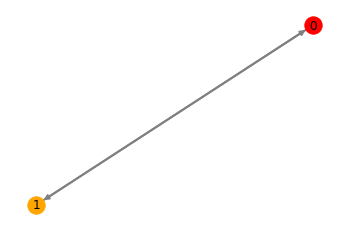

In [29]:
plot_mol(dataset[3])

In [37]:
nx.get_node_attributes(G, "atom_type") , c

({8: 1, 3: 0}, [1, 1, 1, 2])

In [26]:
nx.get_node_attributes(G, "atom_type") , c

({10: 1, 11: 1, 5: 4},
 [1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1])

{0: 1, 1: 4, 2: 1}

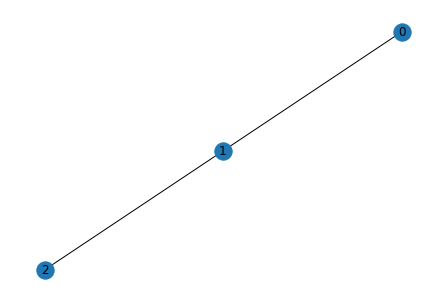

In [16]:
z = nx.Graph()
z.add_nodes_from([
    (0, {"atom_type": 1}),
    (1, {"atom_type": 4}),
    (2, {"atom_type": 1})
])
z.add_edges_from([(0,1), (1,2)])
nx.draw(z, with_labels=True)
nx.get_node_attributes(z, "atom_type")